In [1]:
# Our custom module
from nn import DeepQNetwork
from custom_parking_env import ParkingWithObstacles
from relay_mem import ReplayMemory,Transition

# python module
import gymnasium as gym
import torch
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from itertools import count
from IPython import display

# combine observation
def process_observation(observation):
    observation_vector = np.concatenate((
        observation["observation"],
        observation["achieved_goal"],
        observation["desired_goal"]
    ))
    return observation_vector

# interactive mode
plt.ion()

# Create the original environment and wrap it into an environment with obstacles
env_origin = gym.make("parking-v0", render_mode="human")
env = ParkingWithObstacles(env_origin)
env.define_spaces()

# terminated The episode is over if the ego vehicle crashed or the goal is reached or time is over.
terminated = False

# The episode is truncated if the time is over.
truncated = False

# Print the number of states and actions
print(f"Observation Space: {env.observation_space}")
# observation["observation"] Box(-inf, inf, (6,), float64)
# observation["achieved_goal"] Box(-inf, inf, (6,), float64)
# observation["desired_goal"] Box(-inf, inf, (6,), float64)

print(f"Action Space: {env.action_space}")
# Discrete(5)


# Get the number of state observations
state, info = env.reset()

# Get number of actions from gym action space
n_actions = env.action_space.n
n_observations = len(process_observation(state))  # 6 (observation) + 6 (achieved_goal) + 6 (desired_goal)

Observation Space: Dict('achieved_goal': Box(-inf, inf, (6,), float64), 'desired_goal': Box(-inf, inf, (6,), float64), 'observation': Box(-inf, inf, (6,), float64))
Action Space: Discrete(5)


In [2]:
# if GPU is to be used
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.05
# EPS_DECAY = 1000
# TAU = 0.005
TARGET_UPDATE = 25
LR = 0.0002
EPISODES = 500

policy_net = DeepQNetwork(n_observations, n_actions).to(device)
target_net = DeepQNetwork(n_observations, n_actions).to(device)
# init weight (by policy net)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

# Training loop
num_episodes = EPISODES
epsilon_decay_rate = -np.log(EPS_END / EPS_START) / num_episodes
epsilon_values = []
episode_rewards = []  # Store total rewards per episode
losses = []
episode_durations = []

Using CPU


In [3]:
steps_done = 0
def select_action(state , i_episode):
    global steps_done
    sample = random.random()
    epsilon_threshold = EPS_START * np.exp(-epsilon_decay_rate * i_episode)
    epsilon_values.append(epsilon_threshold)
    steps_done += 1
    if sample > epsilon_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optimize_policy_net():
    # Check if enough transitions are available in replay_buffer
    if len(memory) < BATCH_SIZE:
        return

    # Sample a batch of transitions
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
                        tuple(map(lambda s: s is not None,
                        batch.next_state)), 
                        device=device, 
                        dtype=torch.bool)
    
    non_final_next_states = []
    for s in batch.next_state:
        if s is not None:  # Check if s is not None
            non_final_next_states.append(s)  # Add elements that meet the condition to the list
    
    if len(non_final_next_states) == 0 :
        # Use a placeholder tensor with the appropriate shape
        # Assuming the stqate has a known shape, e.g., (batch_size, state_dim)
        non_final_next_states = tuple(torch.zeros(torch.Size([1, 18]), device=device).unsqueeze(0))
        print("none occur")

    # RuntimeError: torch.cat(): expected a non-empty list of Tensors
    non_final_next_states = torch.cat(non_final_next_states)
    print(non_final_next_states.shape)
    
    # Concatenate batch tensors
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the policy network
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    # for param in policy_net.parameters():
    #     param.grad.data.clamp_(-1, 1)
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    # Track the loss for plotting
    losses.append(loss.item())
    print(f"Loss: {loss.item()}")

def moving_average(data, window_size=50):
    # convolution
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_durations():
    # Create a new figure for the plot
    plt.clf()

    # Convert episode rewards to tensors
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float, device=device)

    # Plot rewards per episode
    plt.subplot(3, 1, 1)
    plt.title('Training Progress (Per Episode)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    # Move GPU tensor back to CPU and convert it to NumPy
    plt.plot(rewards_t.cpu().numpy(), label="Total Reward")
    
    # Add smoothed rewards
    if len(episode_rewards) >= 50:  # Ensure enough data for smoothing
        smoothed_rewards = moving_average(episode_rewards, window_size=50)
        plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Rewards", color='orange')
    plt.legend()

    # Plot losses per step
    plt.subplot(3, 1, 2)
    plt.title('Loss (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.plot(losses, label="Loss", color='red')
    plt.legend()

    # Plot epsilon decay per step
    plt.subplot(3, 1, 3)
    plt.title('Epsilon Decay (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Epsilon')
    plt.plot(epsilon_values, label="Epsilon Decay", color='blue')
    plt.legend()

    # Adjust layout to increase space between plots
    plt.subplots_adjust(hspace=0.5)  # Adjust spacing between rows

    # Pause briefly to update the plot
    plt.pause(0.01)

    # Clear the current output and display the updated plot
    display.display(plt.gcf())

Episode 1 finished after 8 steps


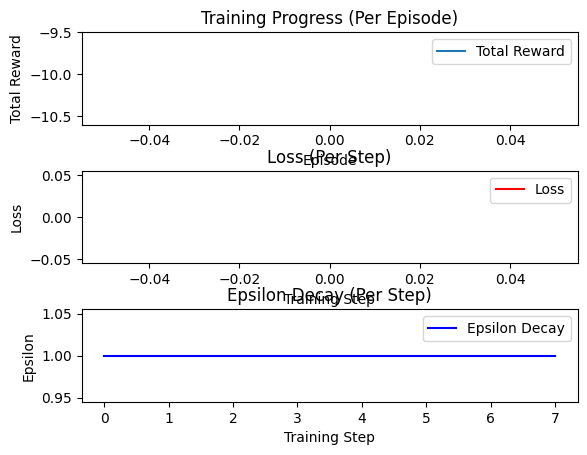

<Figure size 640x480 with 0 Axes>

1 / 500 , R=  -10.050241895848323
Episode 2 finished after 8 steps
2 / 500 , R=  -10.004709933519386
Episode 3 finished after 8 steps
3 / 500 , R=  -8.774652600858193
Episode 4 finished after 7 steps
4 / 500 , R=  -8.079644498846534
Episode 5 finished after 8 steps
5 / 500 , R=  -9.705413769812086
Episode 6 finished after 8 steps
6 / 500 , R=  -9.320110274577026
Episode 7 finished after 7 steps
7 / 500 , R=  -9.362504808293757
Episode 8 finished after 8 steps
8 / 500 , R=  -8.454718627497577
torch.Size([56, 18])
Loss: 0.724414074901415
torch.Size([56, 18])
Loss: 0.7203483437593869
torch.Size([56, 18])
Loss: 0.718022050412799
torch.Size([56, 18])
Loss: 0.716485709153779
torch.Size([57, 18])
Loss: 0.6412319708559464
torch.Size([56, 18])
Loss: 0.7113681693541615
torch.Size([57, 18])
Loss: 0.6343813497687718
torch.Size([57, 18])
Loss: 0.6272966481414939
torch.Size([57, 18])
Loss: 0.6256710393208984
torch.Size([56, 18])
Loss: 0.7040541435536369
torch.Size([56, 18])
Loss: 0.7017698006467306


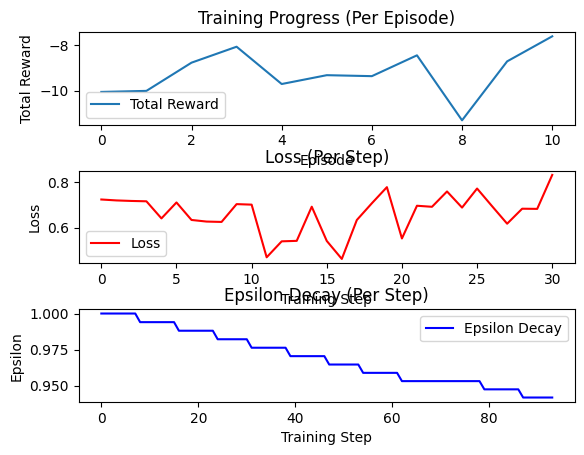

<Figure size 640x480 with 0 Axes>

11 / 500 , R=  -7.625887772300929
torch.Size([59, 18])
Loss: 0.46403221953941504
torch.Size([57, 18])
Loss: 0.6054257626686088
torch.Size([56, 18])
Loss: 0.6869442497995111
torch.Size([58, 18])
Loss: 0.5291992641996871
torch.Size([58, 18])
Loss: 0.530696920066067
torch.Size([59, 18])
Loss: 0.4545448640378368
torch.Size([60, 18])
Loss: 0.3823689464733614
Episode 12 finished after 7 steps
12 / 500 , R=  -7.167963363336199
torch.Size([55, 18])
Loss: 0.7367816341334037
torch.Size([59, 18])
Loss: 0.46102046601380353
torch.Size([58, 18])
Loss: 0.5258537947622871
torch.Size([54, 18])
Loss: 0.8083229926115586
torch.Size([57, 18])
Loss: 0.5880994858901685
torch.Size([55, 18])
Loss: 0.734623303423807
torch.Size([58, 18])
Loss: 0.5301551720048073
torch.Size([56, 18])
Loss: 0.6595754456569352
Episode 13 finished after 8 steps
13 / 500 , R=  -7.7646783622626945
torch.Size([58, 18])
Loss: 0.5022884778910495
torch.Size([56, 18])
Loss: 0.6660507489981983
torch.Size([55, 18])
Loss: 0.7184644854268996
t

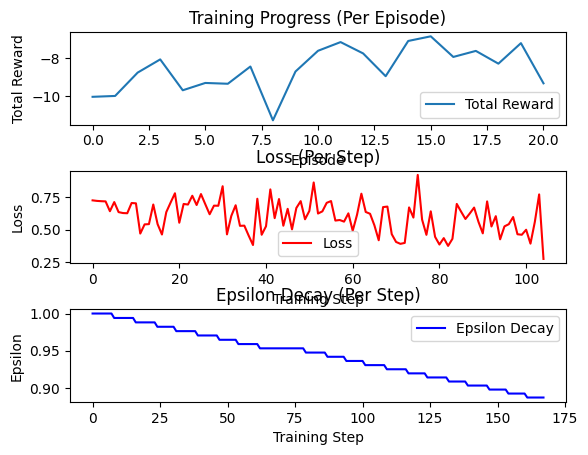

<Figure size 640x480 with 0 Axes>

21 / 500 , R=  -9.339368063677007
torch.Size([54, 18])
Loss: 0.6140666258562975
torch.Size([57, 18])
Loss: 0.46957865614133887
torch.Size([54, 18])
Loss: 0.6147223153216089
torch.Size([57, 18])
Loss: 0.45432125197219797
torch.Size([55, 18])
Loss: 0.5355828755210662
torch.Size([59, 18])
Loss: 0.3146510892612031
torch.Size([56, 18])
Loss: 0.4943251595585334
torch.Size([58, 18])
Loss: 0.331742729684068
Episode 22 finished after 8 steps
22 / 500 , R=  -9.766952144044843
torch.Size([56, 18])
Loss: 0.4985357478945832
torch.Size([57, 18])
Loss: 0.40381507048874943
torch.Size([54, 18])
Loss: 0.5887274516836026
torch.Size([57, 18])
Loss: 0.4357308220263275
torch.Size([54, 18])
Loss: 0.5581631729240332
torch.Size([58, 18])
Loss: 0.3437871883614504
torch.Size([55, 18])
Loss: 0.49605932290627724
Episode 23 finished after 7 steps
23 / 500 , R=  -7.608131655612421
torch.Size([57, 18])
Loss: 0.3779812360867876
torch.Size([58, 18])
Loss: 0.3647998979874104
torch.Size([60, 18])
Loss: 0.2820179612081211

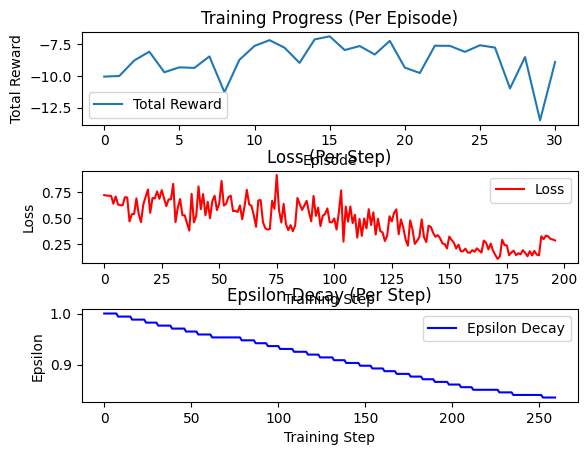

<Figure size 640x480 with 0 Axes>

31 / 500 , R=  -8.894843631123774
torch.Size([55, 18])
Loss: 0.27632958794158596
torch.Size([58, 18])
Loss: 0.4609593792313451
torch.Size([55, 18])
Loss: 0.43410145239909453
torch.Size([57, 18])
Loss: 0.3480263908425638
torch.Size([58, 18])
Loss: 0.3130567775373987
torch.Size([59, 18])
Loss: 0.29131174732171294
torch.Size([58, 18])
Loss: 0.2569983758643205
Episode 32 finished after 7 steps
32 / 500 , R=  -8.307850338744664
torch.Size([56, 18])
Loss: 0.2602360963061944
torch.Size([56, 18])
Loss: 0.5549932073751662
torch.Size([55, 18])
Loss: 0.49083803888522526
torch.Size([52, 18])
Loss: 0.5244223653227649
torch.Size([56, 18])
Loss: 0.42329438112969536
torch.Size([55, 18])
Loss: 0.47689597108153026
torch.Size([58, 18])
Loss: 0.35646553228696914
Episode 33 finished after 7 steps
33 / 500 , R=  -9.117753330480978
torch.Size([57, 18])
Loss: 0.4185755079565644
torch.Size([56, 18])
Loss: 0.6442161227579171
torch.Size([57, 18])
Loss: 0.6598314101605062
torch.Size([60, 18])
Loss: 0.515339646480

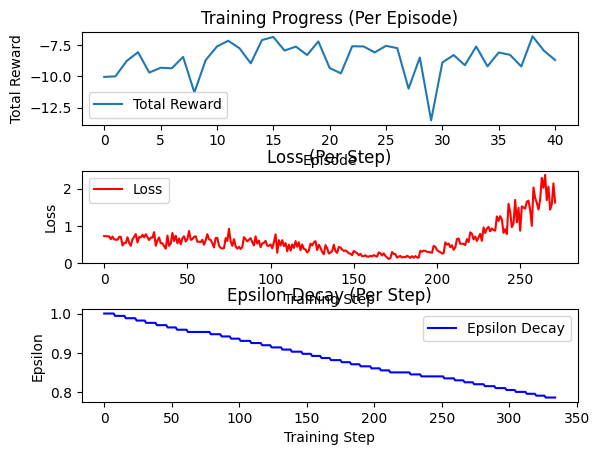

<Figure size 640x480 with 0 Axes>

41 / 500 , R=  -8.702304595504714
torch.Size([58, 18])
Loss: 1.8048610195768227
torch.Size([53, 18])
Loss: 2.971406997152541
torch.Size([57, 18])
Loss: 2.55265766535174
torch.Size([58, 18])
Loss: 2.2817843492239667
torch.Size([60, 18])
Loss: 1.6925823539358158
torch.Size([57, 18])
Loss: 2.2296910333645865
torch.Size([59, 18])
Loss: 1.7021105481455103
torch.Size([53, 18])
Loss: 3.05841177850641
Episode 42 finished after 8 steps
42 / 500 , R=  -8.133644109348747
torch.Size([57, 18])
Loss: 2.2155467002428644
torch.Size([55, 18])
Loss: 3.2402437568778133
torch.Size([55, 18])
Loss: 3.013973838368896
torch.Size([58, 18])
Loss: 2.665639897311848
torch.Size([55, 18])
Loss: 3.0463654738865076
torch.Size([56, 18])
Loss: 2.7304240375049393
torch.Size([55, 18])
Loss: 3.1281577007459944
torch.Size([55, 18])
Loss: 3.054286231607282
Episode 43 finished after 8 steps
43 / 500 , R=  -8.85980612117477
torch.Size([59, 18])
Loss: 2.052185034305744
torch.Size([58, 18])
Loss: 2.9831622910062032
torch.Size([

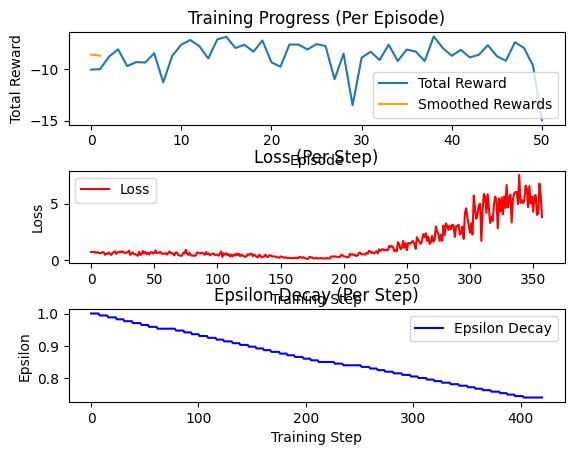

<Figure size 640x480 with 0 Axes>

51 / 500 , R=  -14.974087628903215
torch.Size([58, 18])
Loss: 4.6162293165758035
torch.Size([56, 18])
Loss: 6.426658812280626
torch.Size([53, 18])
Loss: 7.864576013330747
torch.Size([61, 18])
Loss: 3.9946222690068742
torch.Size([59, 18])
Loss: 4.972979271262562
torch.Size([59, 18])
Loss: 5.166963081360038
torch.Size([57, 18])
Loss: 5.891809432628883
torch.Size([55, 18])
Loss: 6.391369149283668
Episode 52 finished after 8 steps
52 / 500 , R=  -8.78103515969647
torch.Size([56, 18])
Loss: 5.781540874247941
torch.Size([58, 18])
Loss: 5.8457097922227925
torch.Size([53, 18])
Loss: 7.759858094420304
torch.Size([50, 18])
Loss: 9.562228057495599
torch.Size([60, 18])
Loss: 4.116203987188046
torch.Size([53, 18])
Loss: 7.668060063074373
torch.Size([55, 18])
Loss: 6.844303233823352
torch.Size([56, 18])
Loss: 6.193529749250239
Episode 53 finished after 8 steps
53 / 500 , R=  -9.048487110116344
torch.Size([59, 18])
Loss: 4.88704767534716
torch.Size([57, 18])
Loss: 7.546400043610094
torch.Size([53, 18

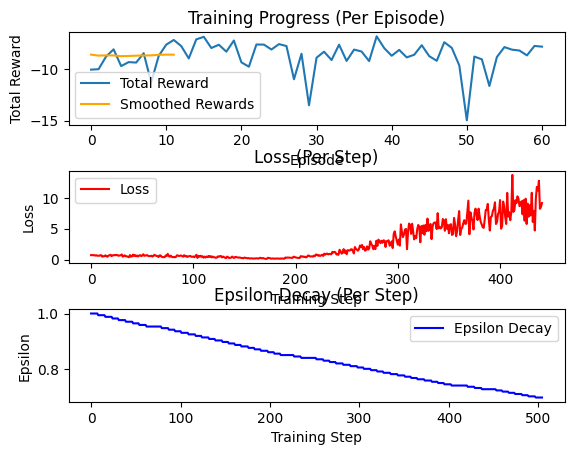

<Figure size 640x480 with 0 Axes>

61 / 500 , R=  -7.817702285876756
torch.Size([60, 18])
Loss: 7.187826887099909
torch.Size([59, 18])
Loss: 8.524040745438043
torch.Size([52, 18])
Loss: 15.279867764326646
torch.Size([56, 18])
Loss: 9.850285344468324
torch.Size([58, 18])
Loss: 9.588185725976441
torch.Size([59, 18])
Loss: 8.034875301688247
torch.Size([56, 18])
Loss: 9.066252011370027
torch.Size([60, 18])
Loss: 7.849350769080645
Episode 62 finished after 8 steps
62 / 500 , R=  -7.297054559227426
torch.Size([57, 18])
Loss: 9.957868166933817
torch.Size([56, 18])
Loss: 11.278746966344805
torch.Size([59, 18])
Loss: 8.34429294042634
torch.Size([55, 18])
Loss: 11.64114468986302
torch.Size([55, 18])
Loss: 11.044967340228695
torch.Size([56, 18])
Loss: 9.749579866424984
torch.Size([56, 18])
Loss: 10.158806503417498
torch.Size([53, 18])
Loss: 13.287964509480961
Episode 63 finished after 8 steps
63 / 500 , R=  -8.869615571096908
torch.Size([55, 18])
Loss: 10.671434918637143
torch.Size([59, 18])
Loss: 7.933721878019684
torch.Size([53,

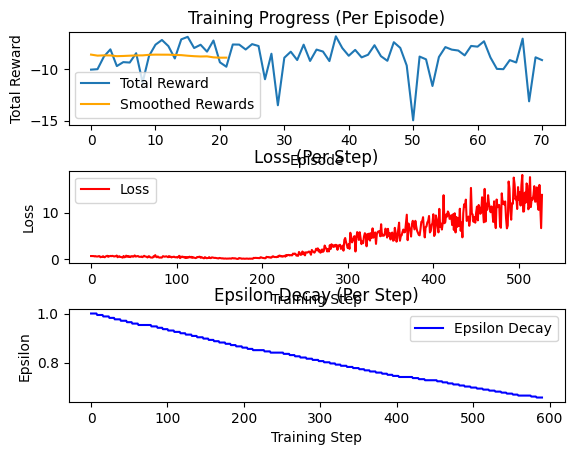

<Figure size 640x480 with 0 Axes>

71 / 500 , R=  -9.12139063042742
torch.Size([53, 18])
Loss: 15.625855282323009
torch.Size([62, 18])
Loss: 7.324951991675105
torch.Size([58, 18])
Loss: 12.944994873120542
torch.Size([55, 18])
Loss: 14.990977214216155
torch.Size([57, 18])
Loss: 13.40362167488112
torch.Size([55, 18])
Loss: 16.58093440484547
torch.Size([61, 18])
Loss: 6.710412518724931
Episode 72 finished after 7 steps
72 / 500 , R=  -7.713703982532611
torch.Size([53, 18])
Loss: 17.308743708575093
torch.Size([53, 18])
Loss: 22.11923286027744
torch.Size([55, 18])
Loss: 16.179115153016664
torch.Size([58, 18])
Loss: 14.541931994253748
torch.Size([56, 18])
Loss: 16.275617734100937
torch.Size([60, 18])
Loss: 8.075341208820333
torch.Size([58, 18])
Loss: 11.253992326926035
torch.Size([57, 18])
Loss: 13.853404424264204
Episode 73 finished after 8 steps
73 / 500 , R=  -9.738395631191278
torch.Size([55, 18])
Loss: 16.06064918539072
torch.Size([56, 18])
Loss: 15.357697889815798
torch.Size([51, 18])
Loss: 21.681637978104835
torch.Size

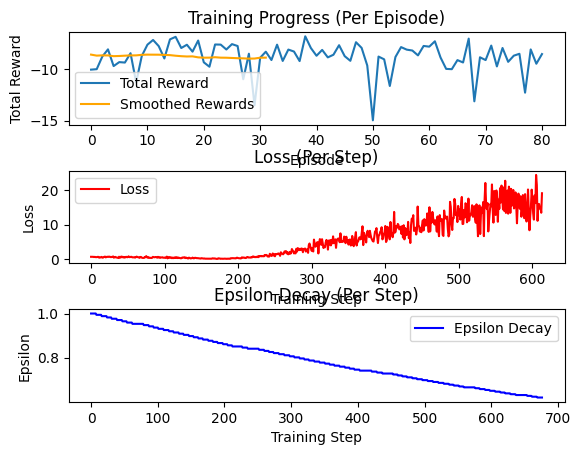

<Figure size 640x480 with 0 Axes>

81 / 500 , R=  -8.537458981185324
torch.Size([55, 18])
Loss: 17.51523777898761
torch.Size([54, 18])
Loss: 19.18177391348188
torch.Size([57, 18])
Loss: 15.218623962080647
torch.Size([57, 18])
Loss: 16.71824825613797
torch.Size([57, 18])
Loss: 15.781151631032726
torch.Size([56, 18])
Loss: 19.425133195197283
torch.Size([59, 18])
Loss: 12.814623655529005
Episode 82 finished after 7 steps
82 / 500 , R=  -8.944120599597396
torch.Size([57, 18])
Loss: 15.179330238534368
torch.Size([57, 18])
Loss: 16.382907834451455
torch.Size([54, 18])
Loss: 22.533416089285986
torch.Size([53, 18])
Loss: 19.294440776112726
torch.Size([59, 18])
Loss: 14.11610945614961
torch.Size([59, 18])
Loss: 13.733761414982594
torch.Size([58, 18])
Loss: 14.299314693024545
torch.Size([54, 18])
Loss: 25.08566874445369
Episode 83 finished after 8 steps
83 / 500 , R=  -9.085798525276825
torch.Size([59, 18])
Loss: 12.814414852966664
torch.Size([47, 18])
Loss: 33.89462506416496
torch.Size([55, 18])
Loss: 18.807964313267124
torch.Si

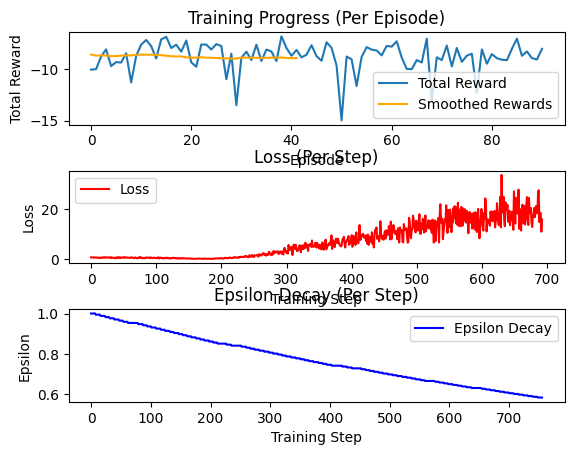

<Figure size 640x480 with 0 Axes>

91 / 500 , R=  -8.032797446993102
torch.Size([55, 18])
Loss: 20.5818367892974
torch.Size([54, 18])
Loss: 26.25489155775786
torch.Size([53, 18])
Loss: 23.98038176115312
torch.Size([54, 18])
Loss: 22.343364838612015
torch.Size([60, 18])
Loss: 13.443179502275157
torch.Size([53, 18])
Loss: 24.41677333846514
torch.Size([57, 18])
Loss: 18.12690120381724
torch.Size([58, 18])
Loss: 15.27984956188017
Episode 92 finished after 8 steps
92 / 500 , R=  -7.025161231231973
torch.Size([54, 18])
Loss: 24.433894861081153
torch.Size([53, 18])
Loss: 22.67980642674179
torch.Size([55, 18])
Loss: 22.102703603458924
torch.Size([53, 18])
Loss: 25.108299305905536
torch.Size([60, 18])
Loss: 16.626774280708197
torch.Size([59, 18])
Loss: 15.250514850101206
torch.Size([52, 18])
Loss: 27.088905701233266
torch.Size([54, 18])
Loss: 21.396541744505726
Episode 93 finished after 8 steps
93 / 500 , R=  -9.047551569109352
torch.Size([58, 18])
Loss: 12.74601570665325
torch.Size([59, 18])
Loss: 19.27175043013657
torch.Size([

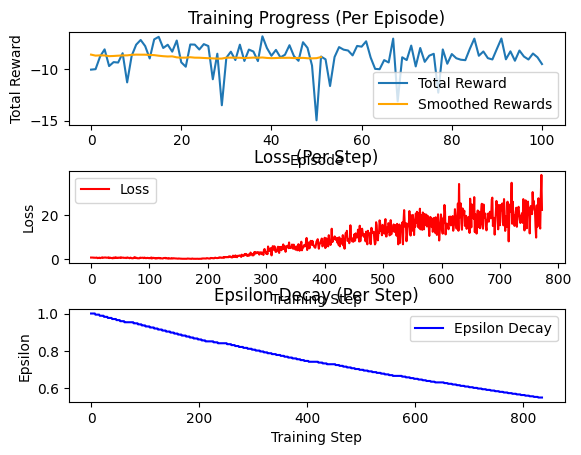

<Figure size 640x480 with 0 Axes>

101 / 500 , R=  -9.508564719483637
torch.Size([59, 18])
Loss: 16.09652672698312
torch.Size([56, 18])
Loss: 21.782391160250206
torch.Size([57, 18])
Loss: 19.83074594385925
torch.Size([55, 18])
Loss: 22.679368919923647
torch.Size([58, 18])
Loss: 15.791539420278522
torch.Size([57, 18])
Loss: 17.491421223561296
torch.Size([57, 18])
Loss: 17.474309308684795
Episode 102 finished after 7 steps
102 / 500 , R=  -7.773637351048307
torch.Size([58, 18])
Loss: 18.884641984284038
torch.Size([55, 18])
Loss: 22.463746426034096
torch.Size([55, 18])
Loss: 26.86416027843482
torch.Size([52, 18])
Loss: 31.055059343831513
torch.Size([59, 18])
Loss: 14.204205475201064
torch.Size([52, 18])
Loss: 28.887693300382914
torch.Size([51, 18])
Loss: 29.759362439739643
torch.Size([61, 18])
Loss: 12.282405149839997
Episode 103 finished after 8 steps
103 / 500 , R=  -6.982184316518212
torch.Size([54, 18])
Loss: 23.680750634527453
torch.Size([54, 18])
Loss: 27.841773120959196
torch.Size([55, 18])
Loss: 22.881453482052816


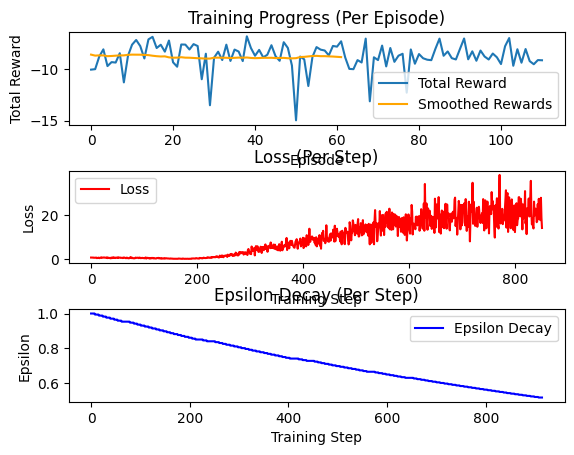

<Figure size 640x480 with 0 Axes>

111 / 500 , R=  -9.139908598836545
torch.Size([60, 18])
Loss: 14.42207407256435
torch.Size([55, 18])
Loss: 24.32187632488329
torch.Size([56, 18])
Loss: 25.911554784879957
torch.Size([52, 18])
Loss: 29.579136775499382
torch.Size([55, 18])
Loss: 26.975093257969185
torch.Size([51, 18])
Loss: 32.584640777477745
torch.Size([58, 18])
Loss: 16.51736728452932
torch.Size([57, 18])
Loss: 17.165234416627975
Episode 112 finished after 8 steps
112 / 500 , R=  -8.496460419616461
torch.Size([52, 18])
Loss: 29.974350903359824
torch.Size([58, 18])
Loss: 21.90206442293372
torch.Size([59, 18])
Loss: 17.28835156726261
torch.Size([55, 18])
Loss: 23.994871047798952
torch.Size([56, 18])
Loss: 27.710551491362388
torch.Size([58, 18])
Loss: 15.409321446182576
torch.Size([52, 18])
Loss: 24.37603895980932
Episode 113 finished after 7 steps
113 / 500 , R=  -8.093494270940745
torch.Size([57, 18])
Loss: 17.42755881423914
torch.Size([56, 18])
Loss: 23.30914887878422
torch.Size([60, 18])
Loss: 12.580335739373561
torch

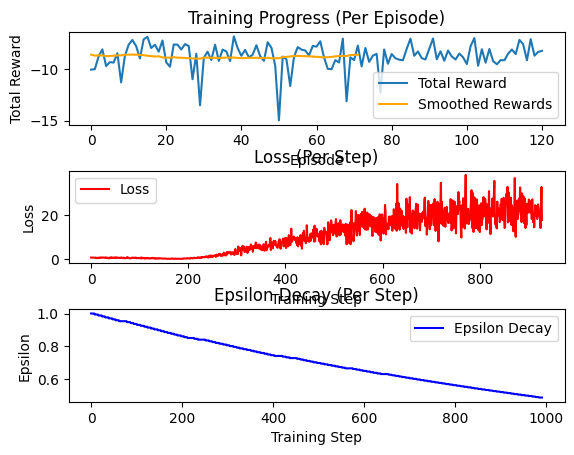

<Figure size 640x480 with 0 Axes>

121 / 500 , R=  -8.223414238541599
torch.Size([51, 18])
Loss: 30.276565831661415
torch.Size([57, 18])
Loss: 18.30857523949949
torch.Size([61, 18])
Loss: 12.170859315779431
torch.Size([58, 18])
Loss: 17.722186820840175
torch.Size([57, 18])
Loss: 17.359848326744
torch.Size([60, 18])
Loss: 15.49099014800613
torch.Size([53, 18])
Loss: 28.199315040338284
torch.Size([57, 18])
Loss: 21.14762839617062
Episode 122 finished after 8 steps
122 / 500 , R=  -6.852212188338639
torch.Size([61, 18])
Loss: 11.570422266061499
torch.Size([53, 18])
Loss: 28.30019573020874
torch.Size([60, 18])
Loss: 12.620416765328368
torch.Size([55, 18])
Loss: 23.511850163015925
torch.Size([58, 18])
Loss: 19.009081253037813
torch.Size([58, 18])
Loss: 14.555466882305012
torch.Size([56, 18])
Loss: 20.30980237356742
torch.Size([59, 18])
Loss: 15.690600783790968
Episode 123 finished after 8 steps
123 / 500 , R=  -8.153826805209906
torch.Size([58, 18])
Loss: 17.327313531475795
torch.Size([53, 18])
Loss: 30.349213814622267
torch

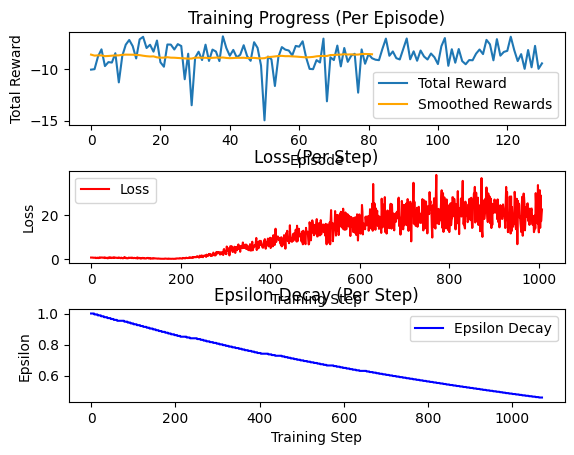

<Figure size 640x480 with 0 Axes>

131 / 500 , R=  -9.442193858345469
torch.Size([50, 18])
Loss: 33.04141934095152
torch.Size([52, 18])
Loss: 30.203655951075234
torch.Size([57, 18])
Loss: 18.324912059559367
torch.Size([60, 18])
Loss: 12.235680088989133
torch.Size([56, 18])
Loss: 21.43045302977404
torch.Size([55, 18])
Loss: 22.703895254104218
torch.Size([56, 18])
Loss: 18.852092848287924
torch.Size([53, 18])
Loss: 25.536390249108898
Episode 132 finished after 8 steps
132 / 500 , R=  -9.047785750383351
torch.Size([61, 18])
Loss: 11.139715696006483
torch.Size([57, 18])
Loss: 18.600275631381017
torch.Size([49, 18])
Loss: 34.54358898053551
torch.Size([55, 18])
Loss: 23.190414927566568
torch.Size([61, 18])
Loss: 11.527604691602233
torch.Size([55, 18])
Loss: 21.317162915724907
torch.Size([60, 18])
Loss: 13.062775181014668
torch.Size([57, 18])
Loss: 18.692044573180056
Episode 133 finished after 8 steps
133 / 500 , R=  -8.32904616560143
torch.Size([52, 18])
Loss: 30.044259365825276
torch.Size([59, 18])
Loss: 15.953480434344135
t

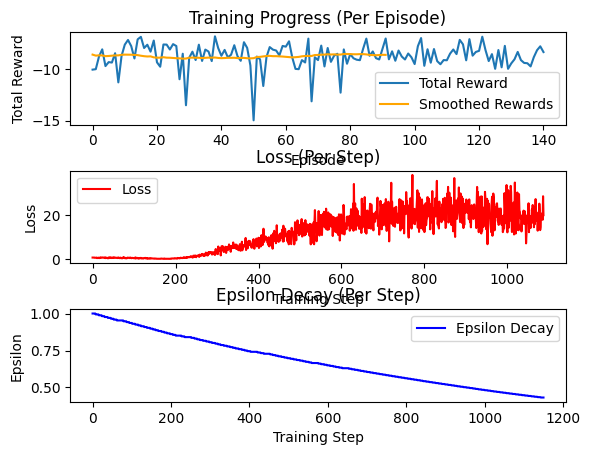

<Figure size 640x480 with 0 Axes>

141 / 500 , R=  -8.343532977526753
torch.Size([59, 18])
Loss: 13.648468545809019
torch.Size([57, 18])
Loss: 21.313075979765333
torch.Size([53, 18])
Loss: 28.75979016679367
torch.Size([55, 18])
Loss: 24.109379631984424
torch.Size([58, 18])
Loss: 20.01860431375917
torch.Size([60, 18])
Loss: 15.059377247373131
torch.Size([50, 18])
Loss: 28.8795367312328
torch.Size([59, 18])
Loss: 13.167346757541814
Episode 142 finished after 8 steps
142 / 500 , R=  -8.366796363312229
torch.Size([57, 18])
Loss: 21.74446711068657
torch.Size([52, 18])
Loss: 28.093392232237065
torch.Size([58, 18])
Loss: 17.830180863629273
torch.Size([55, 18])
Loss: 22.11047844676811
torch.Size([59, 18])
Loss: 17.3674475079064
torch.Size([56, 18])
Loss: 22.95009594218768
torch.Size([61, 18])
Loss: 10.98003039184296
torch.Size([57, 18])
Loss: 21.08340416366871
Episode 143 finished after 8 steps
143 / 500 , R=  -8.605712353585997
torch.Size([56, 18])
Loss: 18.309298537676355
torch.Size([53, 18])
Loss: 31.53289038211514
torch.Siz

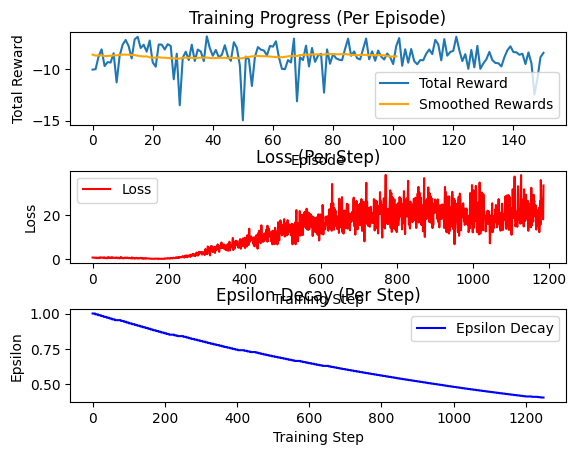

<Figure size 640x480 with 0 Axes>

151 / 500 , R=  -8.416685526066523
torch.Size([54, 18])
Loss: 24.412291499239952
torch.Size([54, 18])
Loss: 26.95641853304287
torch.Size([59, 18])
Loss: 19.101517606198932
torch.Size([55, 18])
Loss: 26.357518651284188
torch.Size([54, 18])
Loss: 19.545037471841933
torch.Size([58, 18])
Loss: 21.466302224753377
torch.Size([58, 18])
Loss: 13.520616306828503
Episode 152 finished after 7 steps
152 / 500 , R=  -8.000612295245173
torch.Size([60, 18])
Loss: 13.650396445604176
torch.Size([55, 18])
Loss: 39.15534145417849
torch.Size([55, 18])
Loss: 20.64217104090157
torch.Size([56, 18])
Loss: 30.838735722977123
torch.Size([52, 18])
Loss: 24.957463769265683
torch.Size([58, 18])
Loss: 17.711292579380743
torch.Size([55, 18])
Loss: 24.203642944682418
torch.Size([60, 18])
Loss: 16.337100099859544
Episode 153 finished after 8 steps
153 / 500 , R=  -8.771144621267862
torch.Size([57, 18])
Loss: 28.27730797968058
torch.Size([54, 18])
Loss: 26.578546953899046
torch.Size([58, 18])
Loss: 20.8872848600568
tor

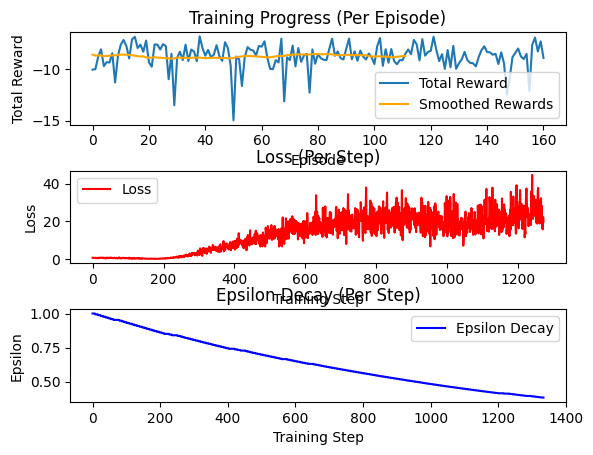

<Figure size 640x480 with 0 Axes>

161 / 500 , R=  -8.915748234087548
torch.Size([57, 18])
Loss: 26.7756262129521
torch.Size([53, 18])
Loss: 27.585396165281054
torch.Size([57, 18])
Loss: 27.00895853272402
torch.Size([55, 18])
Loss: 24.283077151512046
torch.Size([58, 18])
Loss: 13.637400702282694
torch.Size([56, 18])
Loss: 22.415467533113024
torch.Size([58, 18])
Loss: 26.924380248355362
torch.Size([57, 18])
Loss: 24.325538823739315
Episode 162 finished after 8 steps
162 / 500 , R=  -9.761249189488975
torch.Size([58, 18])
Loss: 24.64409661186166
torch.Size([56, 18])
Loss: 26.63838640059102
torch.Size([59, 18])
Loss: 22.388183169572727
torch.Size([58, 18])
Loss: 22.009943965975417
torch.Size([55, 18])
Loss: 27.9359924055668
torch.Size([55, 18])
Loss: 21.85076088776368
torch.Size([55, 18])
Loss: 34.455676044075226
torch.Size([56, 18])
Loss: 25.77585486186169
Episode 163 finished after 8 steps
163 / 500 , R=  -8.495915689949587
torch.Size([54, 18])
Loss: 36.16569611280193
torch.Size([57, 18])
Loss: 28.437377517579087
torch.S

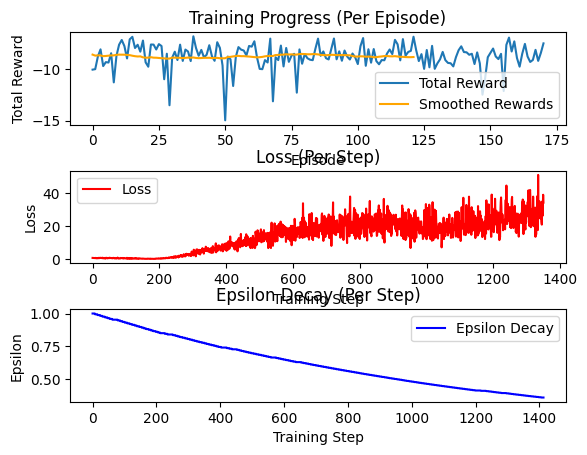

<Figure size 640x480 with 0 Axes>

171 / 500 , R=  -7.499343919339006
torch.Size([57, 18])
Loss: 25.347293671232524
torch.Size([58, 18])
Loss: 30.13613083799995
torch.Size([59, 18])
Loss: 39.138154567233784
torch.Size([52, 18])
Loss: 48.08129497698542
torch.Size([58, 18])
Loss: 29.340470502948378
torch.Size([52, 18])
Loss: 44.43231073692602
torch.Size([52, 18])
Loss: 53.0975151841343
torch.Size([53, 18])
Loss: 41.52021477559984
Episode 172 finished after 8 steps
172 / 500 , R=  -8.54733528741081
torch.Size([55, 18])
Loss: 25.23600146143748
torch.Size([54, 18])
Loss: 42.877070314335455
torch.Size([54, 18])
Loss: 38.734934609118106
torch.Size([52, 18])
Loss: 50.5713870220545
torch.Size([53, 18])
Loss: 33.413661149915924
torch.Size([56, 18])
Loss: 40.89814048241926
torch.Size([60, 18])
Loss: 24.894759516452186
torch.Size([55, 18])
Loss: 45.07770768064525
Episode 173 finished after 8 steps
173 / 500 , R=  -7.096738704932067
torch.Size([55, 18])
Loss: 24.36091231576561
torch.Size([59, 18])
Loss: 29.917134923314844
torch.Size

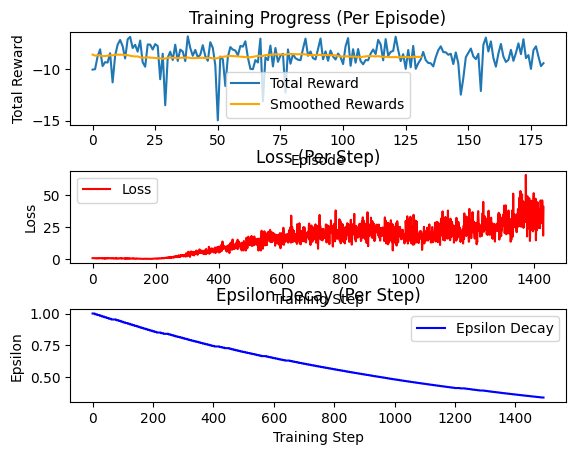

<Figure size 640x480 with 0 Axes>

181 / 500 , R=  -9.421726639067705
torch.Size([58, 18])
Loss: 35.9688827357024
torch.Size([54, 18])
Loss: 27.84383079981891
torch.Size([54, 18])
Loss: 36.19204496191401
torch.Size([56, 18])
Loss: 36.48033634194574
torch.Size([60, 18])
Loss: 19.054700031782808
torch.Size([57, 18])
Loss: 33.96428933530683
torch.Size([58, 18])
Loss: 30.26144845178192
torch.Size([58, 18])
Loss: 29.665690739732526
Episode 182 finished after 8 steps
182 / 500 , R=  -9.138482687925842
torch.Size([56, 18])
Loss: 40.00245923530309
torch.Size([54, 18])
Loss: 42.2264047196737
torch.Size([60, 18])
Loss: 30.866388424429367
torch.Size([58, 18])
Loss: 33.528374110974696
torch.Size([54, 18])
Loss: 29.333663794202266
torch.Size([53, 18])
Loss: 45.99219716139156
torch.Size([56, 18])
Loss: 29.94870567840633
torch.Size([53, 18])
Loss: 44.12965440147753
Episode 183 finished after 8 steps
183 / 500 , R=  -8.474339041421324
torch.Size([53, 18])
Loss: 44.95042639338176
torch.Size([60, 18])
Loss: 37.155782606952414
torch.Size(

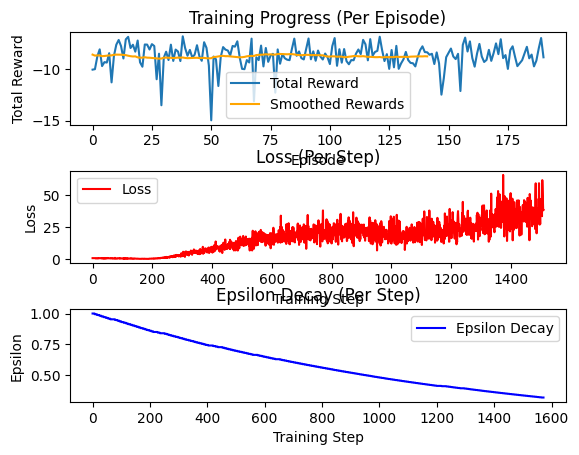

<Figure size 640x480 with 0 Axes>

191 / 500 , R=  -8.851428718685511
torch.Size([58, 18])
Loss: 35.09905695358747
torch.Size([55, 18])
Loss: 49.595779438897964
torch.Size([60, 18])
Loss: 27.92854494402133
torch.Size([52, 18])
Loss: 32.16150448314818
torch.Size([56, 18])
Loss: 46.11517920750955
torch.Size([59, 18])
Loss: 47.57221267596173
torch.Size([58, 18])
Loss: 21.65047547604734
torch.Size([56, 18])
Loss: 25.46721482881697
Episode 192 finished after 8 steps
192 / 500 , R=  -9.667897315578077
torch.Size([51, 18])
Loss: 45.11102452851632
torch.Size([56, 18])
Loss: 49.03405575221859
torch.Size([58, 18])
Loss: 32.531932523582725
torch.Size([55, 18])
Loss: 42.193560606072936
torch.Size([60, 18])
Loss: 36.66169982401291
torch.Size([55, 18])
Loss: 41.43709558853732
torch.Size([58, 18])
Loss: 17.34227250612159
Episode 193 finished after 7 steps
193 / 500 , R=  -6.915749253864894
torch.Size([54, 18])
Loss: 45.76161912396784
torch.Size([56, 18])
Loss: 27.056773518342084
torch.Size([55, 18])
Loss: 52.184039912937514
torch.Size

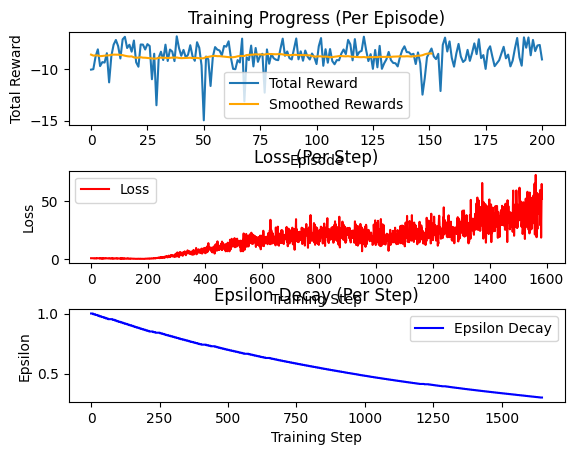

<Figure size 640x480 with 0 Axes>

201 / 500 , R=  -9.059036818320052
torch.Size([56, 18])
Loss: 54.41444720582252
torch.Size([60, 18])
Loss: 20.994171912338643
torch.Size([55, 18])
Loss: 36.30313375002165
torch.Size([55, 18])
Loss: 36.75622762887426
torch.Size([55, 18])
Loss: 19.519626840923355
torch.Size([56, 18])
Loss: 47.418658476445664
torch.Size([51, 18])
Loss: 76.27038922792977
Episode 202 finished after 7 steps
202 / 500 , R=  -8.003470412642692
torch.Size([55, 18])
Loss: 41.05337725969518
torch.Size([56, 18])
Loss: 30.937633769942078
torch.Size([58, 18])
Loss: 44.04315270879014
torch.Size([58, 18])
Loss: 34.50076761032527
torch.Size([57, 18])
Loss: 46.36147221714783
torch.Size([56, 18])
Loss: 25.11718268455308
torch.Size([57, 18])
Loss: 53.60318693836442
torch.Size([55, 18])
Loss: 48.99446544790331
Episode 203 finished after 8 steps
203 / 500 , R=  -9.802811436745104
torch.Size([55, 18])
Loss: 35.53141820859163
torch.Size([58, 18])
Loss: 22.419546501363342
torch.Size([56, 18])
Loss: 51.63147039295629
torch.Size

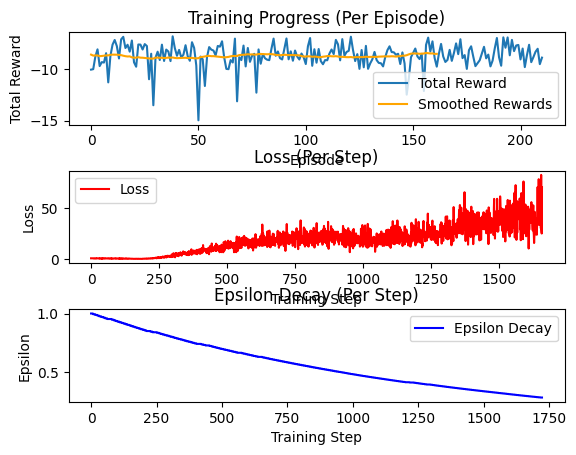

<Figure size 640x480 with 0 Axes>

211 / 500 , R=  -8.885304115649491
torch.Size([55, 18])
Loss: 62.49874336514779
torch.Size([53, 18])
Loss: 43.02266821848928
torch.Size([58, 18])
Loss: 37.401004451066626
torch.Size([54, 18])
Loss: 58.07209142223135
torch.Size([56, 18])
Loss: 18.454330580752853
torch.Size([52, 18])
Loss: 46.030269790426914
torch.Size([59, 18])
Loss: 23.485787338501297
Episode 212 finished after 7 steps
212 / 500 , R=  -8.867773879515386
torch.Size([51, 18])
Loss: 59.85868933647658
torch.Size([53, 18])
Loss: 39.579031959543144
torch.Size([57, 18])
Loss: 47.10211162938759
torch.Size([48, 18])
Loss: 58.62680431414908
torch.Size([61, 18])
Loss: 14.957208784247674
torch.Size([54, 18])
Loss: 43.069400883756316
torch.Size([52, 18])
Loss: 42.462077874386694
torch.Size([53, 18])
Loss: 58.07218390005751
Episode 213 finished after 8 steps
213 / 500 , R=  -8.030963824909323
torch.Size([53, 18])
Loss: 65.2434258486021
torch.Size([56, 18])
Loss: 50.70660025164479
torch.Size([55, 18])
Loss: 55.56221209888835
torch.Si

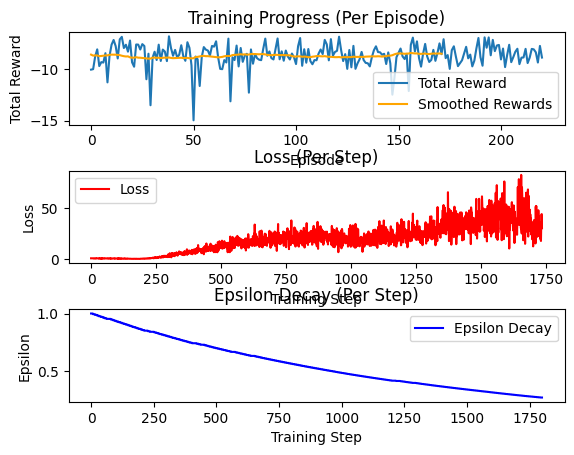

<Figure size 640x480 with 0 Axes>

221 / 500 , R=  -8.876411267643364
torch.Size([54, 18])
Loss: 19.77878417032845
torch.Size([53, 18])
Loss: 47.95056565187726
torch.Size([62, 18])
Loss: 18.036848715087757
torch.Size([57, 18])
Loss: 39.66962596791086
torch.Size([56, 18])
Loss: 33.546843772456725
torch.Size([56, 18])
Loss: 16.06409106296188
torch.Size([54, 18])
Loss: 26.729568449646333
torch.Size([56, 18])
Loss: 38.60746434080353
torch.Size([59, 18])
Loss: 29.609762707373488
torch.Size([55, 18])
Loss: 46.74491045649591
torch.Size([57, 18])
Loss: 33.90219049807546
torch.Size([59, 18])
Loss: 29.460967091604928
torch.Size([55, 18])
Loss: 33.481538066959516
torch.Size([58, 18])
Loss: 23.27888791067887
torch.Size([60, 18])
Loss: 26.176772768725282
torch.Size([56, 18])
Loss: 16.615737322447686
Episode 222 finished after 16 steps
222 / 500 , R=  -11.635423722444532
torch.Size([53, 18])
Loss: 47.069440097416525
torch.Size([55, 18])
Loss: 31.74476031272391
torch.Size([59, 18])
Loss: 21.87202955819969
torch.Size([55, 18])
Loss: 23

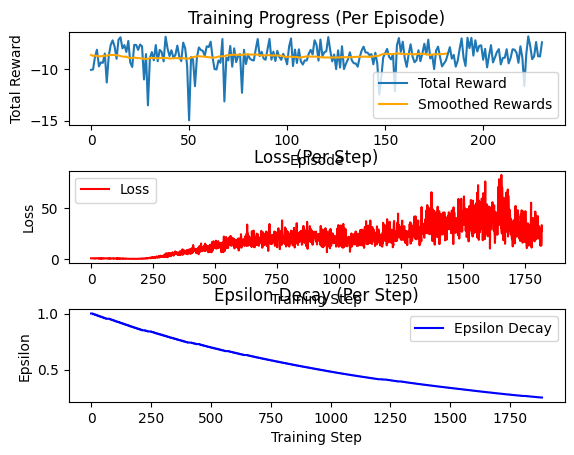

<Figure size 640x480 with 0 Axes>

231 / 500 , R=  -7.358448966162912
torch.Size([58, 18])
Loss: 16.691235434254924
torch.Size([61, 18])
Loss: 16.360681871772663
torch.Size([58, 18])
Loss: 16.515000073168544
torch.Size([54, 18])
Loss: 20.474201879447993
torch.Size([52, 18])
Loss: 18.181963093429463
torch.Size([55, 18])
Loss: 28.575343540510875
torch.Size([60, 18])
Loss: 25.865956009050922
torch.Size([55, 18])
Loss: 22.518815093852712
Episode 232 finished after 8 steps
232 / 500 , R=  -9.187424976053508
torch.Size([58, 18])
Loss: 26.80389275006535
torch.Size([53, 18])
Loss: 33.220636995957406
torch.Size([58, 18])
Loss: 14.825446609116907
torch.Size([59, 18])
Loss: 12.88027748856776
torch.Size([59, 18])
Loss: 22.493311016385853
torch.Size([59, 18])
Loss: 11.60224221377699
torch.Size([48, 18])
Loss: 13.87931145017578
Episode 233 finished after 7 steps
233 / 500 , R=  -7.724618097853715
torch.Size([55, 18])
Loss: 30.06745197469683
torch.Size([58, 18])
Loss: 29.03060769036797
torch.Size([57, 18])
Loss: 11.388779326034875
tor

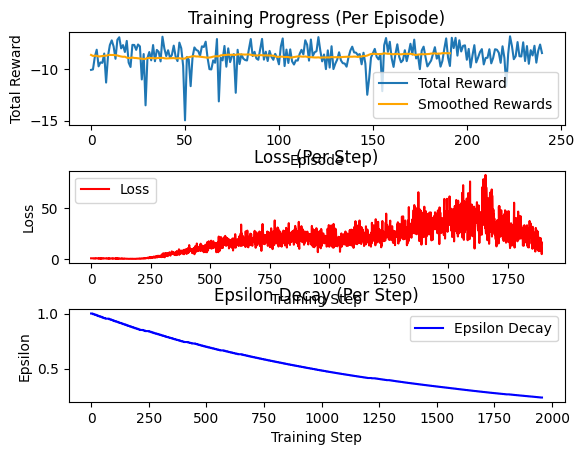

<Figure size 640x480 with 0 Axes>

241 / 500 , R=  -8.406816859821543
torch.Size([59, 18])
Loss: 13.590279940029617
torch.Size([58, 18])
Loss: 9.263271146798907
torch.Size([56, 18])
Loss: 15.963320294144694
torch.Size([57, 18])
Loss: 12.354316620661667
torch.Size([51, 18])
Loss: 19.159097385982243
torch.Size([62, 18])
Loss: 9.394076727889912
torch.Size([56, 18])
Loss: 11.602509228784744
torch.Size([58, 18])
Loss: 10.301148190005344
Episode 242 finished after 8 steps
242 / 500 , R=  -8.388166805959266
torch.Size([57, 18])
Loss: 11.97867076754224
torch.Size([58, 18])
Loss: 13.551892456068472
torch.Size([55, 18])
Loss: 18.617079905142138
torch.Size([58, 18])
Loss: 14.09238006818163
torch.Size([57, 18])
Loss: 13.687958544236116
torch.Size([57, 18])
Loss: 15.426736433940505
torch.Size([61, 18])
Loss: 8.887250529640635
torch.Size([59, 18])
Loss: 9.556367808607103
torch.Size([57, 18])
Loss: 7.684785552178152
torch.Size([58, 18])
Loss: 10.507871300794141
torch.Size([58, 18])
Loss: 16.876640713583335
torch.Size([54, 18])
Loss: 1

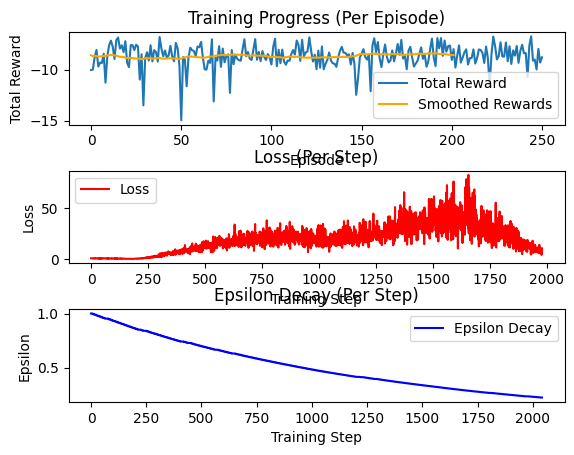

<Figure size 640x480 with 0 Axes>

251 / 500 , R=  -8.803935673999437
torch.Size([59, 18])
Loss: 3.373479562350531
torch.Size([55, 18])
Loss: 7.658929233144628
torch.Size([54, 18])
Loss: 10.728511358359734
torch.Size([58, 18])
Loss: 7.664835708873884
torch.Size([55, 18])
Loss: 11.085073261558437
torch.Size([57, 18])
Loss: 6.657249630261004
torch.Size([57, 18])
Loss: 8.198796033092284
torch.Size([56, 18])
Loss: 7.669892424939073
Episode 252 finished after 8 steps
252 / 500 , R=  -8.002425247246144
torch.Size([56, 18])
Loss: 8.208028243592892
torch.Size([59, 18])
Loss: 8.39129884593266
torch.Size([57, 18])
Loss: 9.702853050452987
torch.Size([57, 18])
Loss: 9.759942209438396
torch.Size([58, 18])
Loss: 9.026799085922818
torch.Size([59, 18])
Loss: 6.680243930999827
torch.Size([59, 18])
Loss: 7.405779993464673
torch.Size([55, 18])
Loss: 7.589511476885349
Episode 253 finished after 8 steps
253 / 500 , R=  -9.369470131093072
torch.Size([58, 18])
Loss: 5.617960337933711
torch.Size([52, 18])
Loss: 10.755785945911864
torch.Size([5

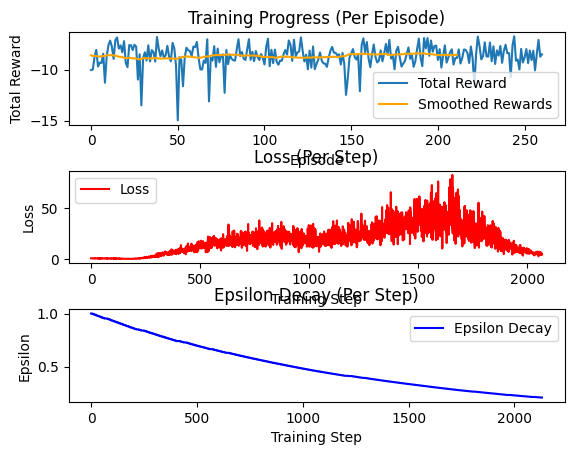

<Figure size 640x480 with 0 Axes>

261 / 500 , R=  -8.511562646057873
torch.Size([55, 18])
Loss: 2.8930784878156657
torch.Size([54, 18])
Loss: 6.274185352563498
torch.Size([56, 18])
Loss: 5.703671410192646
torch.Size([54, 18])
Loss: 4.341750937650807
torch.Size([60, 18])
Loss: 4.788359743053333
torch.Size([57, 18])
Loss: 4.920748232129268
torch.Size([55, 18])
Loss: 3.7815639752248638
torch.Size([55, 18])
Loss: 5.821238567000424
torch.Size([58, 18])
Loss: 4.527081637601275
torch.Size([57, 18])
Loss: 4.470483173517829
torch.Size([55, 18])
Loss: 4.47663149096223
torch.Size([59, 18])
Loss: 3.742469014128144
torch.Size([59, 18])
Loss: 3.8068149721464595
torch.Size([58, 18])
Loss: 2.6895954010468257
torch.Size([54, 18])
Loss: 4.152705055487014
torch.Size([60, 18])
Loss: 2.513525772072474
torch.Size([55, 18])
Loss: 5.199300072383015
torch.Size([57, 18])
Loss: 3.3177921022289474
Episode 262 finished after 18 steps
262 / 500 , R=  -14.573110230963302
torch.Size([56, 18])
Loss: 4.132977245082401
torch.Size([60, 18])
Loss: 4.61656

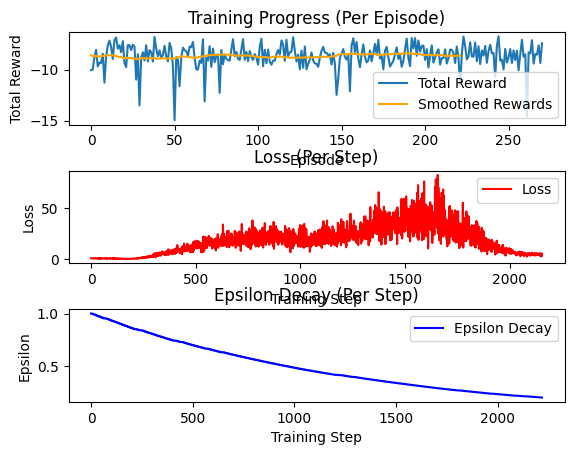

<Figure size 640x480 with 0 Axes>

271 / 500 , R=  -7.432549705803064
torch.Size([52, 18])
Loss: 4.264862533478514
torch.Size([50, 18])
Loss: 4.8387714100978645
torch.Size([52, 18])
Loss: 4.441132492292526
torch.Size([56, 18])
Loss: 4.727233484005579
torch.Size([52, 18])
Loss: 4.933306577270127
torch.Size([54, 18])
Loss: 4.293600224320349
torch.Size([56, 18])
Loss: 3.099221058112367
torch.Size([54, 18])
Loss: 4.268913494644672
Episode 272 finished after 8 steps
272 / 500 , R=  -9.9574514460041
torch.Size([59, 18])
Loss: 3.176214440964622
torch.Size([59, 18])
Loss: 5.605363746910292
torch.Size([54, 18])
Loss: 6.231794035836581
torch.Size([57, 18])
Loss: 3.94727298635532
torch.Size([56, 18])
Loss: 4.7444308339137535
torch.Size([52, 18])
Loss: 3.7554524478009803
torch.Size([54, 18])
Loss: 4.1812608746062825
torch.Size([55, 18])
Loss: 3.4281275870346986
Episode 273 finished after 8 steps
273 / 500 , R=  -9.722053025786359
torch.Size([59, 18])
Loss: 3.3970672468339522
torch.Size([56, 18])
Loss: 3.690185177536672
torch.Size([

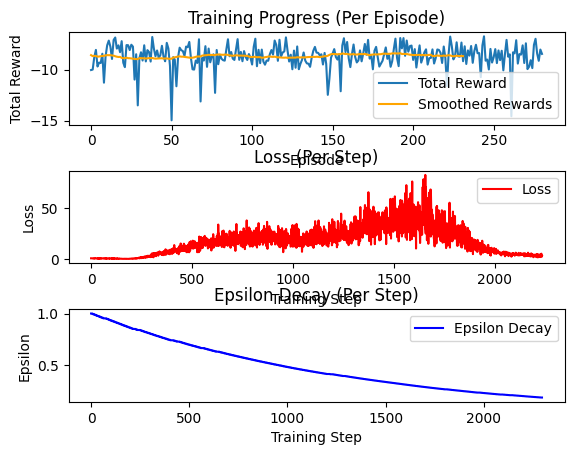

<Figure size 640x480 with 0 Axes>

281 / 500 , R=  -8.469512840887008
torch.Size([57, 18])
Loss: 2.808430324494816
torch.Size([49, 18])
Loss: 3.1529957124978565
torch.Size([55, 18])
Loss: 4.259857530418264
torch.Size([53, 18])
Loss: 4.1823593858664445
torch.Size([57, 18])
Loss: 5.30783036018998
torch.Size([56, 18])
Loss: 3.072894030748451
torch.Size([60, 18])
Loss: 3.2211235231027344
torch.Size([57, 18])
Loss: 2.611633066071726
Episode 282 finished after 8 steps
282 / 500 , R=  -8.250702747430825
torch.Size([58, 18])
Loss: 2.7776701501471694
torch.Size([56, 18])
Loss: 3.6683272251233587
torch.Size([56, 18])
Loss: 4.810364769211194
torch.Size([57, 18])
Loss: 3.576298120135127
torch.Size([53, 18])
Loss: 3.668867987548303
torch.Size([59, 18])
Loss: 3.275521719169742
torch.Size([59, 18])
Loss: 2.4382914887124336
torch.Size([57, 18])
Loss: 2.1258097799169904
Episode 283 finished after 8 steps
283 / 500 , R=  -6.978919945696456
torch.Size([55, 18])
Loss: 3.065223117327039
torch.Size([58, 18])
Loss: 3.8712592450839654
torch.Si

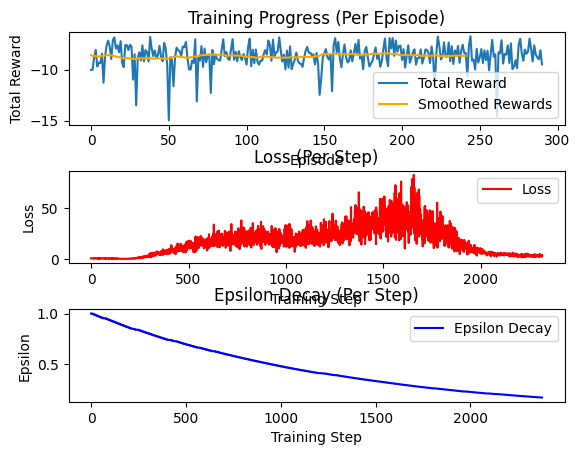

<Figure size 640x480 with 0 Axes>

291 / 500 , R=  -9.495043706882383
torch.Size([53, 18])
Loss: 5.006036268761494
torch.Size([55, 18])
Loss: 3.4225372494672825
torch.Size([55, 18])
Loss: 3.8962091114865527
torch.Size([53, 18])
Loss: 3.8765953135579645
torch.Size([55, 18])
Loss: 3.544988175439397
torch.Size([56, 18])
Loss: 2.425903794630203
torch.Size([55, 18])
Loss: 3.361315830807408
torch.Size([55, 18])
Loss: 3.8129100639804014
Episode 292 finished after 8 steps
292 / 500 , R=  -8.516643182310471
torch.Size([56, 18])
Loss: 3.880706929556762
torch.Size([55, 18])
Loss: 2.6687015146308894
torch.Size([55, 18])
Loss: 4.33132056120799
torch.Size([58, 18])
Loss: 3.3215497781409398
torch.Size([54, 18])
Loss: 3.680674400455447
torch.Size([57, 18])
Loss: 2.968803636452495
torch.Size([53, 18])
Loss: 4.179857963745469
torch.Size([59, 18])
Loss: 3.3716656272352714
torch.Size([56, 18])
Loss: 4.864828931546382
torch.Size([56, 18])
Loss: 3.5877315187821424
torch.Size([59, 18])
Loss: 2.1895527815963716
torch.Size([50, 18])
Loss: 5.059

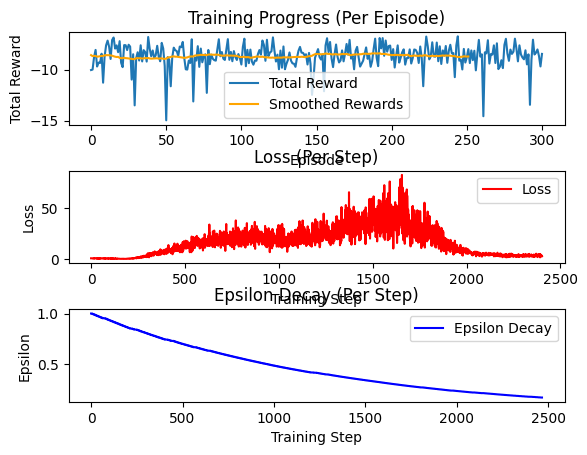

<Figure size 640x480 with 0 Axes>

301 / 500 , R=  -8.46920631336156
torch.Size([55, 18])
Loss: 3.7908947582673065
torch.Size([57, 18])
Loss: 4.031622297177725
torch.Size([55, 18])
Loss: 4.886313774657549
torch.Size([58, 18])
Loss: 3.269139732273943
torch.Size([57, 18])
Loss: 3.8468458984906513
torch.Size([55, 18])
Loss: 3.6902927114209625
torch.Size([58, 18])
Loss: 2.2485825873701577
torch.Size([52, 18])
Loss: 4.697179161300648
Episode 302 finished after 8 steps
302 / 500 , R=  -8.098335829722501
torch.Size([55, 18])
Loss: 3.125770436450063
torch.Size([61, 18])
Loss: 2.623505898351522
torch.Size([58, 18])
Loss: 3.568367354496652
torch.Size([58, 18])
Loss: 3.353991363179306
torch.Size([57, 18])
Loss: 4.16928200586617
torch.Size([55, 18])
Loss: 3.358627832025798
torch.Size([53, 18])
Loss: 4.148562681276351
torch.Size([50, 18])
Loss: 6.110429484782489
Episode 303 finished after 8 steps
303 / 500 , R=  -9.068401048564047
torch.Size([54, 18])
Loss: 3.0463202880965206
torch.Size([56, 18])
Loss: 3.8403368554349386
torch.Size(

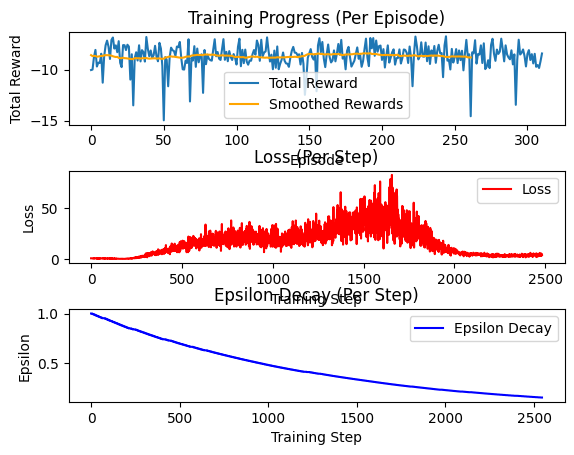

<Figure size 640x480 with 0 Axes>

311 / 500 , R=  -8.428418818136219
torch.Size([61, 18])
Loss: 2.78683636387591
torch.Size([57, 18])
Loss: 4.573320821146927
torch.Size([53, 18])
Loss: 5.258851449483252
torch.Size([60, 18])
Loss: 3.2383951458572198
torch.Size([56, 18])
Loss: 3.718130012261464
torch.Size([59, 18])
Loss: 3.3629220454103894
torch.Size([52, 18])
Loss: 5.937620280431128
torch.Size([56, 18])
Loss: 3.4620403227162404
Episode 312 finished after 8 steps
312 / 500 , R=  -8.843008686120147
torch.Size([55, 18])
Loss: 4.002907982413765
torch.Size([56, 18])
Loss: 3.5708938789218103
torch.Size([58, 18])
Loss: 3.198816095597164
torch.Size([59, 18])
Loss: 3.3716747351563163
torch.Size([59, 18])
Loss: 3.2573080746592806
torch.Size([59, 18])
Loss: 3.643976967403523
torch.Size([57, 18])
Loss: 4.1700315068596385
Episode 313 finished after 7 steps
313 / 500 , R=  -8.18980185856232
torch.Size([56, 18])
Loss: 4.459537934705155
torch.Size([56, 18])
Loss: 4.169039228474221
torch.Size([58, 18])
Loss: 3.3756895456555176
torch.Siz

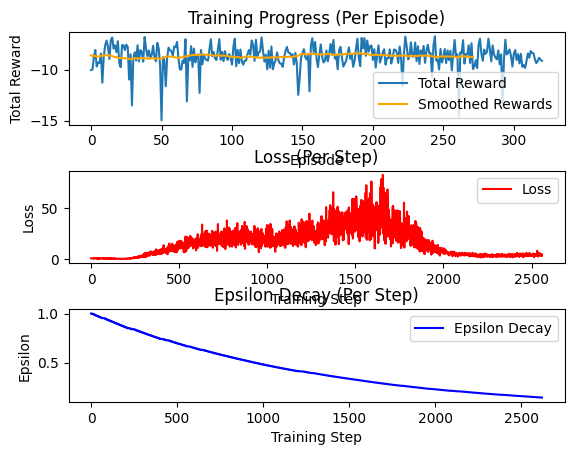

<Figure size 640x480 with 0 Axes>

321 / 500 , R=  -9.149013953027353
torch.Size([57, 18])
Loss: 4.62241812197852
torch.Size([58, 18])
Loss: 4.125075691536343
torch.Size([57, 18])
Loss: 4.1296950170083315
torch.Size([58, 18])
Loss: 3.883578366549105
torch.Size([58, 18])
Loss: 3.4758585848674546
torch.Size([55, 18])
Loss: 5.005937529049598
torch.Size([60, 18])
Loss: 2.5826411038534394
torch.Size([57, 18])
Loss: 4.386832145715854
Episode 322 finished after 8 steps
322 / 500 , R=  -8.755691221344863
torch.Size([58, 18])
Loss: 3.8591377203965824
torch.Size([57, 18])
Loss: 5.890513416580107
torch.Size([60, 18])
Loss: 2.2861215977148763
torch.Size([60, 18])
Loss: 3.135241148253434
torch.Size([55, 18])
Loss: 4.618407205260231
torch.Size([56, 18])
Loss: 4.676159450974012
torch.Size([55, 18])
Loss: 5.672075546148344
torch.Size([57, 18])
Loss: 3.7466333844396686
Episode 323 finished after 8 steps
323 / 500 , R=  -9.11722625363165
torch.Size([51, 18])
Loss: 5.616284681691244
torch.Size([56, 18])
Loss: 5.281989619506569
torch.Size(

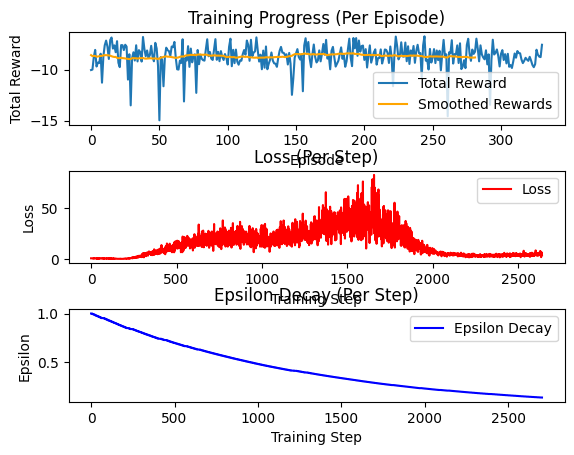

<Figure size 640x480 with 0 Axes>

331 / 500 , R=  -7.575784774900727
torch.Size([59, 18])
Loss: 4.4725715941228
torch.Size([58, 18])
Loss: 4.115736068625002
torch.Size([53, 18])
Loss: 4.86111661708084
torch.Size([61, 18])
Loss: 4.18175001362193
torch.Size([60, 18])
Loss: 2.8922946032284855
torch.Size([56, 18])
Loss: 3.821154896264123
torch.Size([57, 18])
Loss: 4.194957962264095
torch.Size([57, 18])
Loss: 4.329787657669451
Episode 332 finished after 8 steps
332 / 500 , R=  -8.529085345990385
torch.Size([58, 18])
Loss: 4.893888977784463
torch.Size([59, 18])
Loss: 3.4631087995684084
torch.Size([60, 18])
Loss: 4.385354610880702
torch.Size([56, 18])
Loss: 4.93154598958914
torch.Size([57, 18])
Loss: 3.936618570960471
torch.Size([57, 18])
Loss: 3.654429486219931
torch.Size([59, 18])
Loss: 4.263389139026857
torch.Size([56, 18])
Loss: 5.172596076396496
Episode 333 finished after 8 steps
333 / 500 , R=  -7.169914400464263
torch.Size([53, 18])
Loss: 5.039165015404436
torch.Size([55, 18])
Loss: 5.443174466323294
torch.Size([56, 18

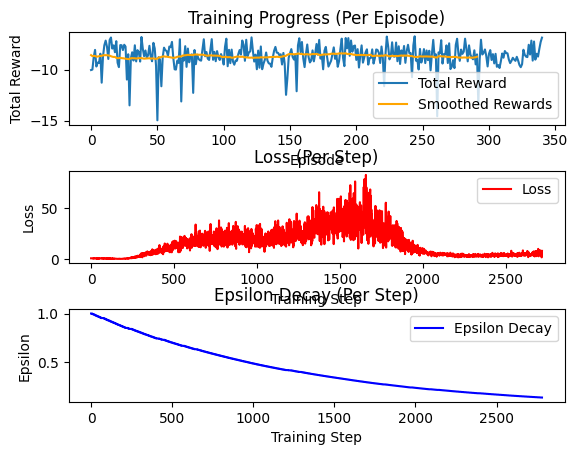

<Figure size 640x480 with 0 Axes>

341 / 500 , R=  -6.876451490963941
torch.Size([61, 18])
Loss: 2.552468699510176
torch.Size([54, 18])
Loss: 6.1177421726014
torch.Size([59, 18])
Loss: 4.254457839078093
torch.Size([53, 18])
Loss: 7.103184922087896
torch.Size([58, 18])
Loss: 2.9977221451070113
torch.Size([59, 18])
Loss: 3.6207971155786027
torch.Size([58, 18])
Loss: 4.749403071603966
torch.Size([61, 18])
Loss: 3.3354498379004487
Episode 342 finished after 8 steps
342 / 500 , R=  -9.195681589981717
torch.Size([57, 18])
Loss: 5.7586698114128545
torch.Size([57, 18])
Loss: 3.9865840604624116
torch.Size([61, 18])
Loss: 4.445384738383039
torch.Size([55, 18])
Loss: 6.478359876998174
torch.Size([57, 18])
Loss: 3.803092172874492
torch.Size([59, 18])
Loss: 3.7676276643787405
torch.Size([59, 18])
Loss: 4.835840267800821
torch.Size([54, 18])
Loss: 7.340522478359421
Episode 343 finished after 8 steps
343 / 500 , R=  -8.891682200554971
torch.Size([49, 18])
Loss: 7.631626511625214
torch.Size([59, 18])
Loss: 3.474344153652018
torch.Size(

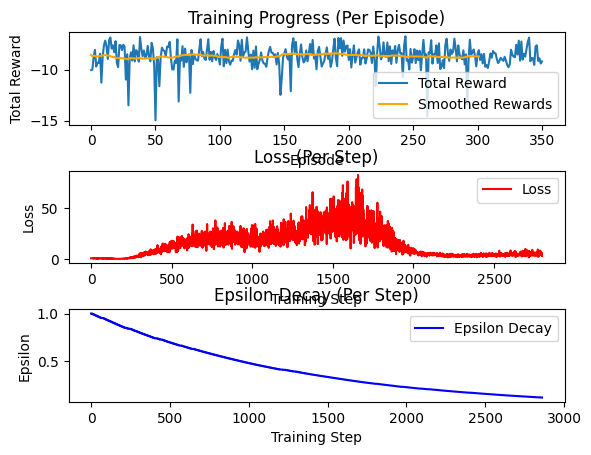

<Figure size 640x480 with 0 Axes>

351 / 500 , R=  -9.209727410942245
torch.Size([55, 18])
Loss: 3.943483886250449
torch.Size([56, 18])
Loss: 4.1633122776246765
torch.Size([60, 18])
Loss: 4.54751886756703
torch.Size([51, 18])
Loss: 8.468689575933167
torch.Size([53, 18])
Loss: 5.010056164005558
torch.Size([57, 18])
Loss: 4.518167223737317
torch.Size([54, 18])
Loss: 6.091722963120473
torch.Size([53, 18])
Loss: 6.828586997556759
Episode 352 finished after 8 steps
352 / 500 , R=  -8.562576092675759
torch.Size([58, 18])
Loss: 4.801866525885766
torch.Size([59, 18])
Loss: 5.055086876204863
torch.Size([54, 18])
Loss: 6.50668958122765
torch.Size([56, 18])
Loss: 4.8242822495613416
torch.Size([58, 18])
Loss: 5.376087003081875
torch.Size([59, 18])
Loss: 4.8555374015821755
torch.Size([53, 18])
Loss: 7.498654953735958
torch.Size([55, 18])
Loss: 5.379060092946983
Episode 353 finished after 8 steps
353 / 500 , R=  -8.814905145995617
torch.Size([58, 18])
Loss: 3.0727265079261357
torch.Size([59, 18])
Loss: 4.061995611785069
torch.Size([4

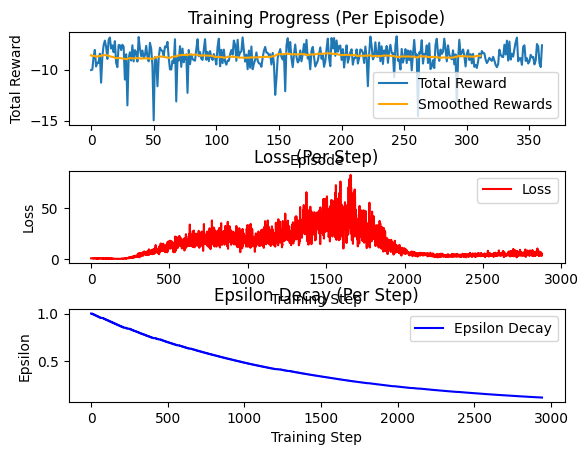

<Figure size 640x480 with 0 Axes>

361 / 500 , R=  -7.626038026906667
torch.Size([49, 18])
Loss: 7.713840843150966
torch.Size([54, 18])
Loss: 4.20590343420097
torch.Size([57, 18])
Loss: 4.518083384447982
torch.Size([53, 18])
Loss: 5.64470123891568
torch.Size([54, 18])
Loss: 4.471292744320909
torch.Size([55, 18])
Loss: 4.712989128733423
torch.Size([59, 18])
Loss: 5.975774407758491
torch.Size([59, 18])
Loss: 4.340768039974609
Episode 362 finished after 8 steps
362 / 500 , R=  -8.2089527584435
torch.Size([58, 18])
Loss: 3.9459955076405127
torch.Size([57, 18])
Loss: 4.356944395937963
torch.Size([56, 18])
Loss: 4.286070917096638
torch.Size([58, 18])
Loss: 5.09109549935163
torch.Size([53, 18])
Loss: 8.512753657205852
torch.Size([51, 18])
Loss: 6.062754283363148
torch.Size([57, 18])
Loss: 4.564428875249742
Episode 363 finished after 7 steps
363 / 500 , R=  -7.377753107104402
torch.Size([57, 18])
Loss: 5.572395413787174
torch.Size([59, 18])
Loss: 3.5470241633483828
torch.Size([59, 18])
Loss: 2.9849465241654842
torch.Size([48, 1

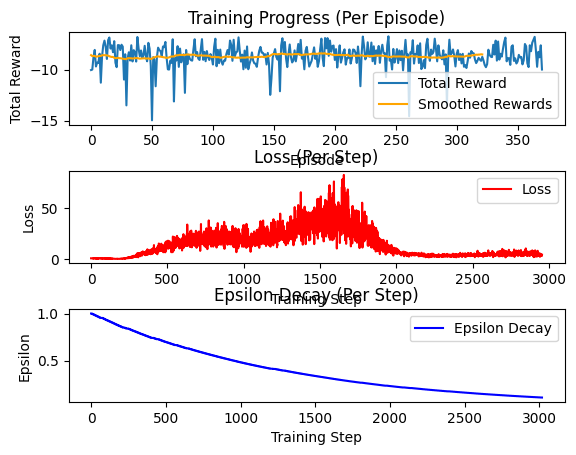

<Figure size 640x480 with 0 Axes>

371 / 500 , R=  -9.999914148963684
torch.Size([55, 18])
Loss: 4.242510898470663
torch.Size([53, 18])
Loss: 4.623836351336795
torch.Size([58, 18])
Loss: 3.346292598773646
torch.Size([56, 18])
Loss: 3.1141780777697825
torch.Size([50, 18])
Loss: 5.6534204822055365
torch.Size([56, 18])
Loss: 3.9941767467668847
torch.Size([58, 18])
Loss: 3.9863784276714824
torch.Size([58, 18])
Loss: 3.440256948181974
Episode 372 finished after 8 steps
372 / 500 , R=  -9.682600032576925
torch.Size([57, 18])
Loss: 2.8246154193143127
torch.Size([54, 18])
Loss: 4.599834715617959
torch.Size([55, 18])
Loss: 4.263068760488002
torch.Size([57, 18])
Loss: 4.5219909085069485
torch.Size([57, 18])
Loss: 4.465024674286472
torch.Size([60, 18])
Loss: 2.4594475694054507
torch.Size([59, 18])
Loss: 1.7459099595088956
torch.Size([54, 18])
Loss: 3.930472164540057
Episode 373 finished after 8 steps
373 / 500 , R=  -7.789108708927541
torch.Size([58, 18])
Loss: 3.463605913482004
torch.Size([55, 18])
Loss: 3.6811403505201428
torch.

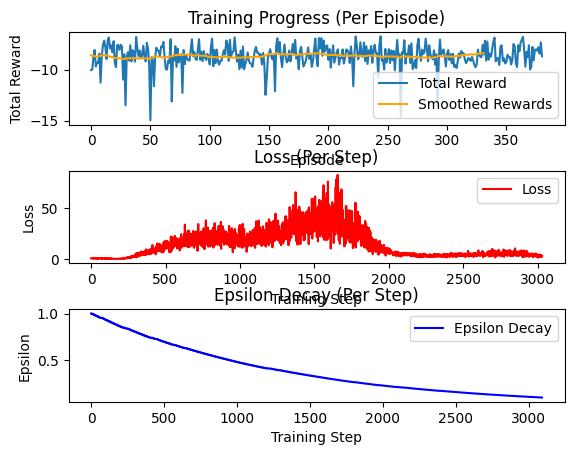

<Figure size 640x480 with 0 Axes>

381 / 500 , R=  -8.703689658760876
torch.Size([57, 18])
Loss: 2.491534212221069
torch.Size([59, 18])
Loss: 2.677448088917583
torch.Size([57, 18])
Loss: 3.1120358939679122
torch.Size([54, 18])
Loss: 3.490437848536903
torch.Size([52, 18])
Loss: 3.288667184750607
torch.Size([54, 18])
Loss: 3.1099490385036264
torch.Size([56, 18])
Loss: 2.721313365966659
torch.Size([53, 18])
Loss: 2.632392493254139
Episode 382 finished after 8 steps
382 / 500 , R=  -8.489906061996685
torch.Size([55, 18])
Loss: 3.1338484218471194
torch.Size([56, 18])
Loss: 2.604398335871733
torch.Size([60, 18])
Loss: 2.095473260982172
torch.Size([57, 18])
Loss: 2.2581418696354643
torch.Size([54, 18])
Loss: 3.3744727373743935
torch.Size([54, 18])
Loss: 3.0545738482193334
torch.Size([56, 18])
Loss: 3.0509169264025147
Episode 383 finished after 7 steps
383 / 500 , R=  -9.32472664334934
torch.Size([59, 18])
Loss: 1.9323242196237052
torch.Size([56, 18])
Loss: 2.975352119745537
torch.Size([58, 18])
Loss: 2.4009451457161286
torch.S

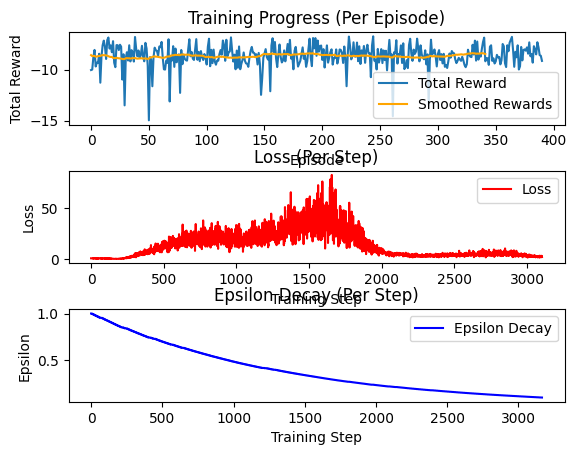

<Figure size 640x480 with 0 Axes>

391 / 500 , R=  -9.156614017926483
torch.Size([57, 18])
Loss: 1.9939624700826624
torch.Size([58, 18])
Loss: 2.5979150299107956
torch.Size([60, 18])
Loss: 2.0620841266082888
torch.Size([57, 18])
Loss: 2.4869098415368844
torch.Size([55, 18])
Loss: 1.9544541040573835
torch.Size([55, 18])
Loss: 2.4545382243325253
torch.Size([54, 18])
Loss: 2.6480583784531677
Episode 392 finished after 7 steps
392 / 500 , R=  -8.57751317593706
torch.Size([54, 18])
Loss: 2.5274654328595796
torch.Size([58, 18])
Loss: 2.2231476793027944
torch.Size([56, 18])
Loss: 2.710299864874603
torch.Size([54, 18])
Loss: 2.5035941702930744
torch.Size([58, 18])
Loss: 2.4075255668026534
torch.Size([58, 18])
Loss: 2.4770048395614417
torch.Size([59, 18])
Loss: 1.7360592034977462
torch.Size([58, 18])
Loss: 2.2931971864178546
Episode 393 finished after 8 steps
393 / 500 , R=  -9.195281920887407
torch.Size([57, 18])
Loss: 2.0670255518422276
torch.Size([50, 18])
Loss: 2.724031152955196
torch.Size([53, 18])
Loss: 3.4202622762202646


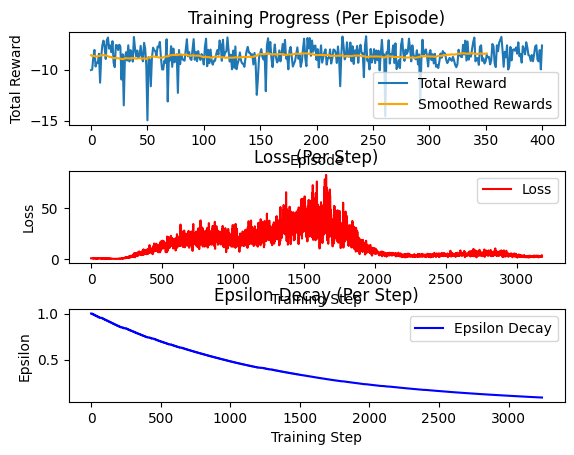

<Figure size 640x480 with 0 Axes>

401 / 500 , R=  -7.649515023790107
torch.Size([56, 18])
Loss: 2.4151280267063227
torch.Size([52, 18])
Loss: 3.3253168255403094
torch.Size([62, 18])
Loss: 1.7955251250156168
torch.Size([57, 18])
Loss: 2.297739079021283
torch.Size([59, 18])
Loss: 2.222864939697263
torch.Size([58, 18])
Loss: 2.4050365332907444
torch.Size([54, 18])
Loss: 2.8256408583957087
torch.Size([58, 18])
Loss: 2.230556349530923
torch.Size([55, 18])
Loss: 2.6100758714717034
torch.Size([58, 18])
Loss: 2.7056379071184984
torch.Size([56, 18])
Loss: 1.8972574257619683
torch.Size([58, 18])
Loss: 1.7765695312035452
torch.Size([57, 18])
Loss: 2.6187399701173555
torch.Size([54, 18])
Loss: 2.473152670840803
torch.Size([57, 18])
Loss: 2.3869052789403495
torch.Size([59, 18])
Loss: 2.1330769872313566
Episode 402 finished after 16 steps
402 / 500 , R=  -10.150373203519639
torch.Size([54, 18])
Loss: 2.317895112894755
torch.Size([55, 18])
Loss: 2.3049181600837145
torch.Size([57, 18])
Loss: 2.5068973840044224
torch.Size([55, 18])
Los

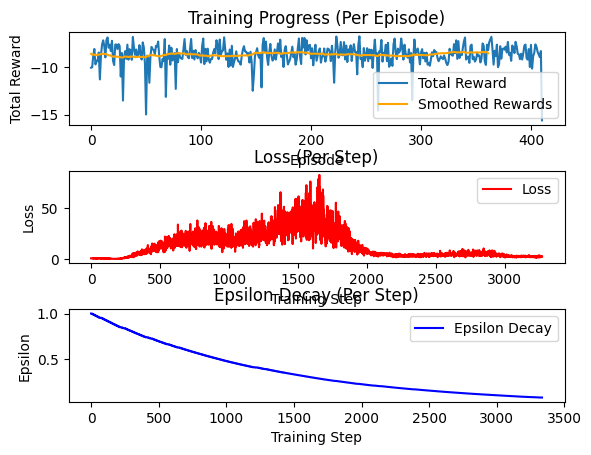

<Figure size 640x480 with 0 Axes>

411 / 500 , R=  -15.594959677612625
torch.Size([59, 18])
Loss: 1.4491540219525114
torch.Size([49, 18])
Loss: 3.043251222941879
torch.Size([57, 18])
Loss: 1.733056139048194
torch.Size([58, 18])
Loss: 1.9831929360963545
torch.Size([58, 18])
Loss: 1.7978815345319694
torch.Size([56, 18])
Loss: 1.8714857208941773
torch.Size([55, 18])
Loss: 1.9304110355811013
Episode 412 finished after 7 steps
412 / 500 , R=  -9.173613991915403
torch.Size([53, 18])
Loss: 2.4888127277931322
torch.Size([54, 18])
Loss: 2.3055114908312984
torch.Size([55, 18])
Loss: 2.2680936783143983
torch.Size([60, 18])
Loss: 1.7098810773814623
torch.Size([57, 18])
Loss: 2.2532610321476483
torch.Size([59, 18])
Loss: 1.824186821985467
torch.Size([59, 18])
Loss: 1.876788889447129
Episode 413 finished after 7 steps
413 / 500 , R=  -8.058862720075279
torch.Size([60, 18])
Loss: 2.412484712605792
torch.Size([57, 18])
Loss: 1.9069424100559762
torch.Size([58, 18])
Loss: 2.3408308994147826
torch.Size([54, 18])
Loss: 2.119688644995719
to

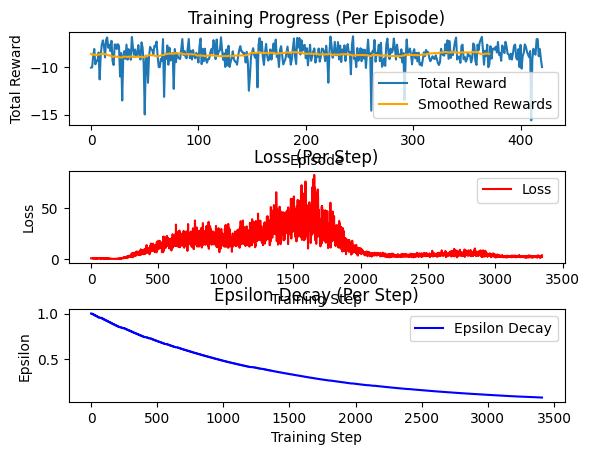

<Figure size 640x480 with 0 Axes>

421 / 500 , R=  -9.983349843448877
torch.Size([55, 18])
Loss: 2.6228927259765227
torch.Size([57, 18])
Loss: 2.106774926461752
torch.Size([57, 18])
Loss: 1.9463155098727087
torch.Size([56, 18])
Loss: 2.0930307687784113
torch.Size([54, 18])
Loss: 2.6671012857195504
torch.Size([55, 18])
Loss: 2.0245832013878893
torch.Size([53, 18])
Loss: 2.206928614754519
torch.Size([56, 18])
Loss: 2.8109961335660545
Episode 422 finished after 8 steps
422 / 500 , R=  -7.904222778109442
torch.Size([57, 18])
Loss: 2.286950585913888
torch.Size([54, 18])
Loss: 3.125407525362455
torch.Size([54, 18])
Loss: 2.306313840337105
torch.Size([56, 18])
Loss: 1.9939995122910918
torch.Size([59, 18])
Loss: 1.6896711499885242
torch.Size([54, 18])
Loss: 2.076579976578194
torch.Size([59, 18])
Loss: 1.872654407689394
torch.Size([52, 18])
Loss: 2.9024831812035536
Episode 423 finished after 8 steps
423 / 500 , R=  -8.816853270582534
torch.Size([56, 18])
Loss: 2.3665703962048426
torch.Size([57, 18])
Loss: 1.908164370788918
torch

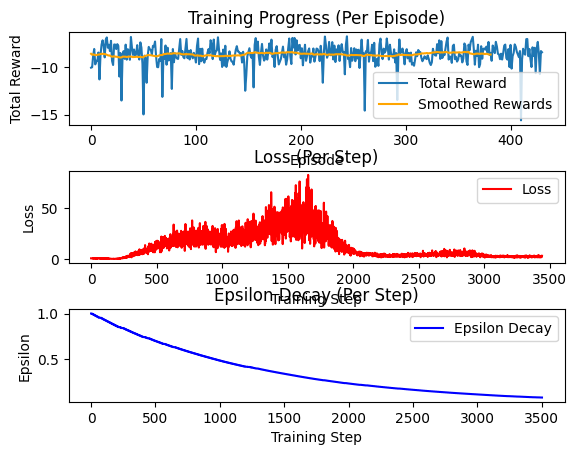

<Figure size 640x480 with 0 Axes>

431 / 500 , R=  -8.424955124590715
torch.Size([56, 18])
Loss: 2.9944650821845142
torch.Size([59, 18])
Loss: 1.8928204469948522
torch.Size([57, 18])
Loss: 2.0043237750829586
torch.Size([53, 18])
Loss: 3.236137963484391
torch.Size([54, 18])
Loss: 2.920084077140508
torch.Size([57, 18])
Loss: 2.10212035844403
torch.Size([55, 18])
Loss: 2.7806739025269627
torch.Size([55, 18])
Loss: 2.8758810402988297
Episode 432 finished after 8 steps
432 / 500 , R=  -6.990508179406544
torch.Size([56, 18])
Loss: 2.2293827146382044
torch.Size([60, 18])
Loss: 1.6184602920968612
torch.Size([59, 18])
Loss: 1.9519196628388127
torch.Size([58, 18])
Loss: 1.9470438907387235
torch.Size([56, 18])
Loss: 2.6977155729722337
torch.Size([55, 18])
Loss: 2.694629959391151
torch.Size([54, 18])
Loss: 3.4086696202470694
Episode 433 finished after 7 steps
433 / 500 , R=  -7.752166791939651
torch.Size([59, 18])
Loss: 1.5408591381131678
torch.Size([55, 18])
Loss: 2.4322954894457363
torch.Size([53, 18])
Loss: 2.0976504786068997
to

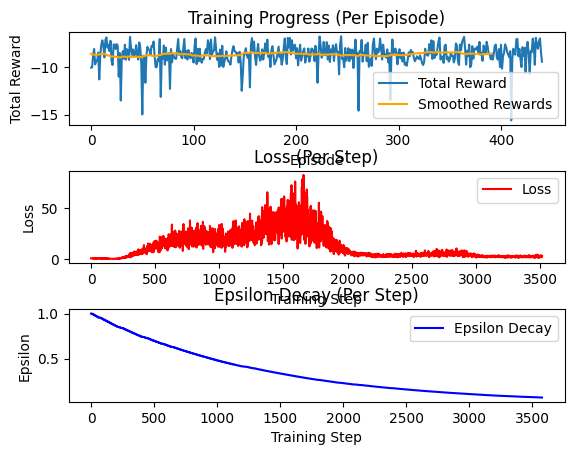

<Figure size 640x480 with 0 Axes>

441 / 500 , R=  -9.419752151505477
torch.Size([53, 18])
Loss: 3.3365339363844626
torch.Size([56, 18])
Loss: 2.804762968025169
torch.Size([56, 18])
Loss: 2.1273719457273845
torch.Size([58, 18])
Loss: 1.8896416782555803
torch.Size([61, 18])
Loss: 1.6145121933309932
torch.Size([55, 18])
Loss: 2.7223442428022753
torch.Size([58, 18])
Loss: 2.2514079307927193
Episode 442 finished after 7 steps
442 / 500 , R=  -7.541752949709427
torch.Size([51, 18])
Loss: 3.2964955148700357
torch.Size([55, 18])
Loss: 2.395853340282702
torch.Size([59, 18])
Loss: 1.9317364656246774
torch.Size([56, 18])
Loss: 2.5079579597094686
torch.Size([55, 18])
Loss: 2.546139290630926
torch.Size([56, 18])
Loss: 2.4425677818663583
torch.Size([57, 18])
Loss: 2.864565648101598
torch.Size([56, 18])
Loss: 2.3315299127716775
Episode 443 finished after 8 steps
443 / 500 , R=  -9.98039146157279
torch.Size([57, 18])
Loss: 2.314054333827105
torch.Size([54, 18])
Loss: 2.635982357693373
torch.Size([53, 18])
Loss: 3.2173258335777675
torc

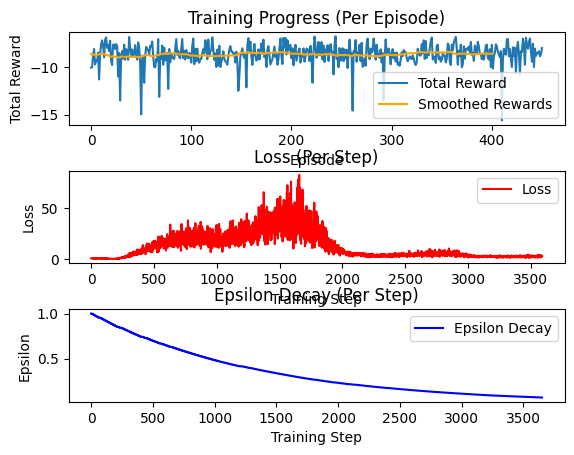

<Figure size 640x480 with 0 Axes>

451 / 500 , R=  -7.979867568460332
torch.Size([55, 18])
Loss: 2.7864074684831808
torch.Size([58, 18])
Loss: 2.265157293070984
torch.Size([55, 18])
Loss: 2.5513045091904605
torch.Size([56, 18])
Loss: 2.5773281532392014
torch.Size([58, 18])
Loss: 1.8988892703546212
torch.Size([60, 18])
Loss: 1.8712359087296193
torch.Size([55, 18])
Loss: 2.830773347559836
torch.Size([57, 18])
Loss: 2.3893224303207603
Episode 452 finished after 8 steps
452 / 500 , R=  -7.896777767249465
torch.Size([55, 18])
Loss: 2.72806513706575
torch.Size([54, 18])
Loss: 3.0131705934898485
torch.Size([56, 18])
Loss: 2.5550193111256605
torch.Size([61, 18])
Loss: 1.3486142104076269
torch.Size([59, 18])
Loss: 2.0322336090265076
torch.Size([55, 18])
Loss: 2.9427406442738295
torch.Size([58, 18])
Loss: 2.191540747664199
torch.Size([56, 18])
Loss: 2.6183908632521833
Episode 453 finished after 8 steps
453 / 500 , R=  -8.78462185809293
torch.Size([57, 18])
Loss: 2.409937802821868
torch.Size([60, 18])
Loss: 1.6382975793605206
torc

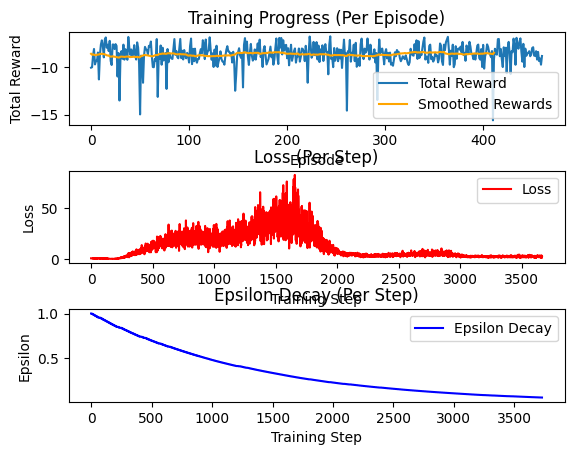

<Figure size 640x480 with 0 Axes>

461 / 500 , R=  -8.82148122740149
torch.Size([57, 18])
Loss: 2.392089876711341
torch.Size([54, 18])
Loss: 2.9613435932454193
torch.Size([57, 18])
Loss: 2.3382036697514863
torch.Size([58, 18])
Loss: 1.9824828224128463
torch.Size([56, 18])
Loss: 2.8045530588068117
torch.Size([55, 18])
Loss: 2.688976245112885
torch.Size([52, 18])
Loss: 3.2577599862299316
Episode 462 finished after 7 steps
462 / 500 , R=  -8.423522701186638
torch.Size([57, 18])
Loss: 2.307370078847615
torch.Size([52, 18])
Loss: 3.55589691728782
torch.Size([56, 18])
Loss: 2.352362101909317
torch.Size([54, 18])
Loss: 2.9873910572212425
torch.Size([58, 18])
Loss: 1.9222291494813786
torch.Size([58, 18])
Loss: 2.0282700738003365
torch.Size([59, 18])
Loss: 2.0669790171297318
Episode 463 finished after 7 steps
463 / 500 , R=  -8.698049516471041
torch.Size([58, 18])
Loss: 2.030763080999776
torch.Size([61, 18])
Loss: 1.336543795581212
torch.Size([56, 18])
Loss: 2.4886912108640438
torch.Size([57, 18])
Loss: 2.339419206760921
torch.S

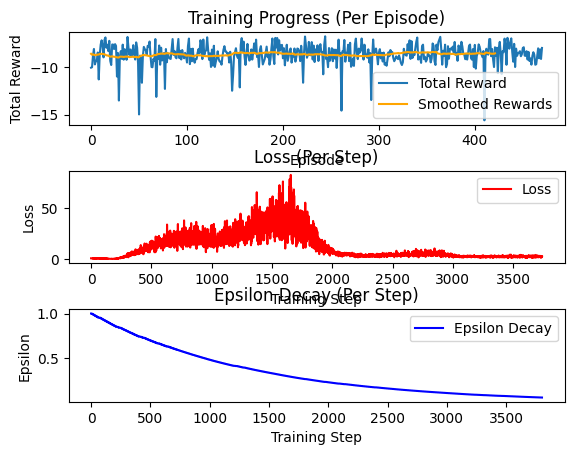

<Figure size 640x480 with 0 Axes>

471 / 500 , R=  -7.973801416007179
torch.Size([59, 18])
Loss: 1.4995676538327583
torch.Size([59, 18])
Loss: 1.5632440633278386
torch.Size([59, 18])
Loss: 1.6836340377136858
torch.Size([54, 18])
Loss: 2.743151393038057
torch.Size([54, 18])
Loss: 2.9150885873544023
torch.Size([56, 18])
Loss: 2.1997440630796237
torch.Size([55, 18])
Loss: 2.573748377043965
torch.Size([56, 18])
Loss: 2.238981559601098
Episode 472 finished after 8 steps
472 / 500 , R=  -8.778396464924198
torch.Size([57, 18])
Loss: 1.9002274864934587
torch.Size([57, 18])
Loss: 2.0237119789235063
torch.Size([59, 18])
Loss: 1.6403138122310623
torch.Size([57, 18])
Loss: 2.1490584366120666
torch.Size([55, 18])
Loss: 2.683417242376281
torch.Size([60, 18])
Loss: 1.3243327596385297
torch.Size([56, 18])
Loss: 2.2620329004021755
torch.Size([58, 18])
Loss: 1.6780237395973634
Episode 473 finished after 8 steps
473 / 500 , R=  -8.573739614163554
torch.Size([53, 18])
Loss: 2.6064299265703905
torch.Size([54, 18])
Loss: 2.603673420910742
to

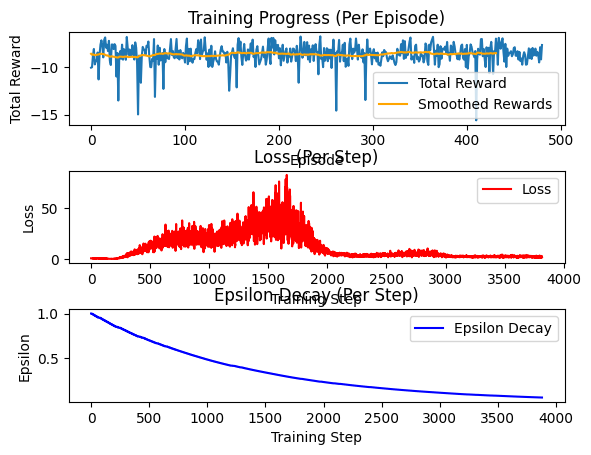

<Figure size 640x480 with 0 Axes>

481 / 500 , R=  -7.6625391484944965
torch.Size([58, 18])
Loss: 1.737336730015961
torch.Size([55, 18])
Loss: 2.2288675427545175
torch.Size([58, 18])
Loss: 1.6335042899517318
torch.Size([57, 18])
Loss: 1.723400588305116
torch.Size([54, 18])
Loss: 2.2542336193876555
torch.Size([61, 18])
Loss: 1.1103490356536083
torch.Size([57, 18])
Loss: 1.8241683114900766
Episode 482 finished after 7 steps
482 / 500 , R=  -8.594939894408702
torch.Size([56, 18])
Loss: 2.076549807736744
torch.Size([54, 18])
Loss: 2.424552948429417
torch.Size([61, 18])
Loss: 1.0129658974959714
torch.Size([59, 18])
Loss: 1.2859049597644778
torch.Size([56, 18])
Loss: 2.0087000786568
torch.Size([52, 18])
Loss: 2.7495915994335096
torch.Size([60, 18])
Loss: 1.1777607610692538
torch.Size([52, 18])
Loss: 2.522749161653641
Episode 483 finished after 8 steps
483 / 500 , R=  -9.520482536262916
torch.Size([53, 18])
Loss: 2.579528470540414
torch.Size([57, 18])
Loss: 1.6139191639313282
torch.Size([60, 18])
Loss: 1.109869478183963
torch.

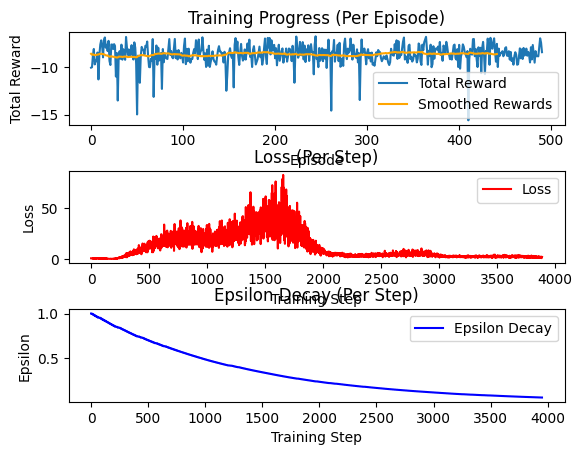

<Figure size 640x480 with 0 Axes>

491 / 500 , R=  -8.418469807926002
torch.Size([50, 18])
Loss: 2.8970059134623782
torch.Size([55, 18])
Loss: 1.903882855936207
torch.Size([53, 18])
Loss: 2.0043962023867063
torch.Size([58, 18])
Loss: 1.2462375928042269
torch.Size([57, 18])
Loss: 1.5423352396291683
torch.Size([59, 18])
Loss: 1.0571381039704315
torch.Size([56, 18])
Loss: 1.8737127852763946
torch.Size([56, 18])
Loss: 1.5343665820392873
Episode 492 finished after 8 steps
492 / 500 , R=  -9.153579918023656
torch.Size([55, 18])
Loss: 1.7856909758212964
torch.Size([56, 18])
Loss: 1.6239989881302155
torch.Size([59, 18])
Loss: 1.2471387330013362
torch.Size([57, 18])
Loss: 1.419909219154571
torch.Size([59, 18])
Loss: 1.1864992758540223
torch.Size([58, 18])
Loss: 1.1145176040335933
torch.Size([58, 18])
Loss: 1.2355962305297912
torch.Size([52, 18])
Loss: 2.2856462068235848
Episode 493 finished after 8 steps
493 / 500 , R=  -9.217058602162718
torch.Size([54, 18])
Loss: 1.6770062725517598
torch.Size([55, 18])
Loss: 1.7378782718773174

<Figure size 640x480 with 0 Axes>

In [4]:
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    observation, info = env.reset()
    observation_vector = process_observation(observation)
    observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)
    
    total_reward = 0  # Track total reward for this episode

    for t in count():
        action = select_action(observation_tensor,i_episode)
        observation, reward, done, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        total_reward += reward.item()  # Accumulate rewards

        if done or truncated:
            next_state = None
        else:
            observation_vector = process_observation(observation)
            next_state = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(observation_tensor, action, next_state, reward)

        # Move to the next state
        observation_tensor = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_policy_net()

        if done or truncated: 
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)  # Save total reward for this episode
            if truncated:
                print(f"Episode {i_episode + 1} truncated after {t + 1} steps")
            else:
                print(f"Episode {i_episode + 1} finished after {t + 1} steps")
            if i_episode % 10 == 0:
                plot_training_durations()
            break

        # Update target network (weights)
        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
    
    print(i_episode + 1,'/',num_episodes, ', R= ', episode_rewards[i_episode])

print('Training is finished')
plt.ioff()
plt.show()

In [5]:
# # Initialize the environment and get its state
# observation, info = env.reset()
# observation_vector = process_observation(observation)
# observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)
# print(observation_tensor.shape)
# print(info)

# action = select_action(observation_tensor,i_episode)
# print(action)

# observation, reward, done, truncated, _ = env.step(action.item())
# print(observation)
# print(done)

# reward = torch.tensor([reward], device=device)
# print(reward)
# out = env.compute_reward(observation["achieved_goal"],observation["desired_goal"],{})
# print(out > -env.config["success_goal_reward"])

In [6]:
env.close()

In [7]:
print(torch.zeros(torch.Size([1, 18])))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
